In [1]:
from sqlalchemy import create_engine
import numpy as np
import pandas as pd
import pandas.io.sql as sqlio
import os
from dotenv import load_dotenv
import datetime as dt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, Birch
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import pickle as pkl
import json

In [2]:
RANDOM_STATE = 42

# Read Data

In [3]:
# Curry function to initialize postgres engine and return read_query function

def make_read_query(protocol=None, user=None, password=None, host=None, port=None, db=None):
    load_dotenv()
    
    protocol = protocol if protocol else 'postgresql+psycopg2'
    user = user if user else os.environ.get('POSTGRES_USER')
    password = password if password else os.environ.get('POSTGRES_PASSWORD')
    host = host if host else 'localhost'
    port = port if port else 5432
    db = db if db else os.environ.get('POSTGRES_DB')
    
    db_url = f'{protocol}://{user}:{password}@{host}:{port}/{db}'
    engine = create_engine(db_url)

    def read_query(query, verbose=True):
        if verbose:
            print(query, '\n')
            
        with engine.connect() as conn:
            df = sqlio.read_sql_query(query, conn)

        return df

    return read_query

In [4]:
read_query = make_read_query()

In [5]:
users_enriched = read_query("SELECT * FROM users_enriched")
users_enriched.head()

SELECT * FROM users_enriched 



,id,age,gender,country,city,traffic_source,created_at,first_order_timestamp,last_order_timestamp,days_to_activation,...,avg_order_items,max_order_items,avg_item_value,max_item_value,avg_order_value,max_order_value,order_items,lifetime_status,segment,predicted_segment
0,56219,60,F,United States,Philadelphia,Facebook,2019-01-02 00:06:00,2021-05-27 23:07:12,2021-05-27 23:07:12,876.0,...,1.0,1.0,74.990,74.99,74.990,74.99,"{""(70373,\""WranglerÂ® Booty Up Stretch Jean fo...",Churned,None,None
1,9418,69,F,United Kingdom,Cardiff,Search,2019-01-02 00:36:00,2021-07-30 12:35:12,2023-04-21 14:50:59,940.0,...,1.0,1.0,221.500,399.00,221.500,399.00,"{""(90353,\""Colleen Skirt Slip\"",Women,Intimate...",Active,None,None
2,21731,65,F,China,Harbin,Email,2019-01-02 01:47:00,2023-09-17 22:23:37,2023-09-17 22:23:37,1719.0,...,4.0,4.0,60.985,169.98,243.940,243.94,"{""(27173,\""Modadorn New Arrivals Spring & fall...",Active,None,None
3,39594,17,M,China,Shenzhen,Search,2019-01-02 03:00:00,2019-02-11 03:06:43,2019-10-25 02:29:03,40.0,...,1.0,1.0,35.975,51.96,35.975,51.96,"{""(49470,\""Billabong Men's Semi-Button Up Stri...",Churned,None,None
4,2000,30,F,China,Hefei,Search,2019-01-02 03:19:00,NaT,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,None,Inactive,None,None


In [6]:
users_enriched.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84011 entries, 0 to 84010
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     84011 non-null  int64         
 1   age                    84011 non-null  int64         
 2   gender                 84011 non-null  object        
 3   country                84011 non-null  object        
 4   city                   84011 non-null  object        
 5   traffic_source         84011 non-null  object        
 6   created_at             84011 non-null  datetime64[ns]
 7   first_order_timestamp  58293 non-null  datetime64[ns]
 8   last_order_timestamp   58293 non-null  datetime64[ns]
 9   days_to_activation     58293 non-null  float64       
 10  active_days            58293 non-null  float64       
 11  inactive_days          58293 non-null  float64       
 12  avg_days_to_order      21899 non-null  float64       
 13  s

In [7]:
users_enriched.describe()

,id,age,created_at,first_order_timestamp,last_order_timestamp,days_to_activation,active_days,inactive_days,avg_days_to_order,std_days_to_order,n_orders,avg_order_items,max_order_items,avg_item_value,max_item_value,avg_order_value,max_order_value
count,84011.000000,84011.000000,84011,58293,58293,58293.000000,58293.000000,58293.000000,21899.000000,58293.000000,84011.000000,58293.000000,58293.000000,58293.000000,58293.000000,58293.000000,58293.00000
mean,50064.425611,41.062706,2021-06-14 10:42:19.902130176,2022-08-02 13:44:07.089473024,2023-01-06 23:26:35.611471104,430.072530,157.218071,379.122073,286.277227,25.738270,1.119937,1.490248,1.638224,59.397607,87.070144,86.045600,107.95719
min,1.000000,12.000000,2019-01-02 00:06:00,2019-01-06 02:25:41,2019-01-06 02:25:41,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.020000,0.020000,0.020000,0.02000
25%,25108.500000,26.000000,2020-02-20 04:11:00,2021-10-12 13:24:51,2022-07-01 13:01:12,103.000000,0.000000,80.000000,84.000000,0.000000,0.000000,1.000000,1.000000,29.945000,34.990000,34.990000,38.00000
50%,50099.000000,41.000000,2021-05-23 03:56:00,2022-11-11 09:55:21,2023-05-16 14:03:19,310.000000,0.000000,249.000000,205.000000,0.000000,1.000000,1.000000,1.000000,46.470000,60.000000,62.000000,74.74000
75%,75017.500000,56.000000,2022-09-24 04:51:30,2023-08-09 14:54:31,2023-11-02 00:05:26,659.000000,172.000000,568.000000,403.000000,0.000000,2.000000,2.000000,2.000000,70.983333,109.990000,109.350000,144.29000
max,100000.000000,70.000000,2024-01-16 19:46:14.316147,2024-01-21 10:09:51.990337,2024-01-21 12:55:19.720387,1828.000000,1759.000000,1841.000000,1744.000000,1222.000000,25.000000,4.000000,4.000000,999.000000,999.000000,1341.490000,1347.29000
std,28864.127943,17.034090,NaN,NaN,NaN,399.416052,305.310117,377.716575,274.826897,90.569301,1.150198,0.755906,0.923900,53.434791,88.762539,83.088805,108.72422


# EDA

In [8]:
inactive_users = users_enriched.loc[users_enriched.n_orders==0].copy()
one_off_customers = users_enriched.loc[users_enriched.n_orders==1].copy()
repeat_purchasers = users_enriched.loc[users_enriched.n_orders>1].copy()

print('Repeat Purchasers:', repeat_purchasers.shape[0], 
      'One-Off Customers', one_off_customers.shape[0], 
      'Inactive Users', inactive_users.shape[0])

Repeat Purchasers: 21899 One-Off Customers 36394 Inactive Users 25718


In [9]:
one_off_customers['segment'] = 'One-Off Customers'
inactive_users['segment'] = 'Never Ordered'

In [10]:
CLUSTERING_FEATURES = ['n_orders', 'avg_days_to_order', 'avg_order_items', 'max_order_items', 'avg_item_value', 'max_item_value']
X = repeat_purchasers[CLUSTERING_FEATURES]

In [11]:
X.describe()

,n_orders,avg_days_to_order,avg_order_items,max_order_items,avg_item_value,max_item_value
count,21899.000000,21899.000000,21899.000000,21899.000000,21899.000000,21899.000000
mean,2.634504,286.277227,1.562537,1.956436,59.726520,115.483605
std,1.133329,274.826897,0.658002,1.015058,38.024806,100.995169
min,2.000000,0.000000,1.000000,1.000000,4.470000,5.950000
25%,2.000000,84.000000,1.000000,1.000000,36.225000,55.000000
50%,2.000000,205.000000,1.000000,2.000000,51.195000,88.950000
75%,3.000000,403.000000,2.000000,2.000000,72.040143,148.000000
max,25.000000,1744.000000,4.000000,4.000000,571.500000,999.000000


In [12]:
def plot_histograms(df, columns=None, width=14, height=7, bins=20):
    columns = df.columns if columns is None else columns
    n_subplots = len(columns)
    n_subplot_rows = round(np.sqrt(n_subplots))
    n_subplot_cols = n_subplots / n_subplot_rows

    n_subplot_cols = int(n_subplot_cols) + 1 if n_subplot_cols % 1 > 0 else int(n_subplot_cols)
    
    fig, axs = plt.subplots(n_subplot_rows, n_subplot_cols)
    fig.set_figwidth(14)
    fig.set_figheight(7)

    for i, col in enumerate(columns):
        ax_row = i // n_subplot_cols
        ax_col = i % n_subplot_cols
        ax = axs[ax_row,ax_col]
        ax.set_title(col)
        df[col].hist(bins=bins, ax=ax)

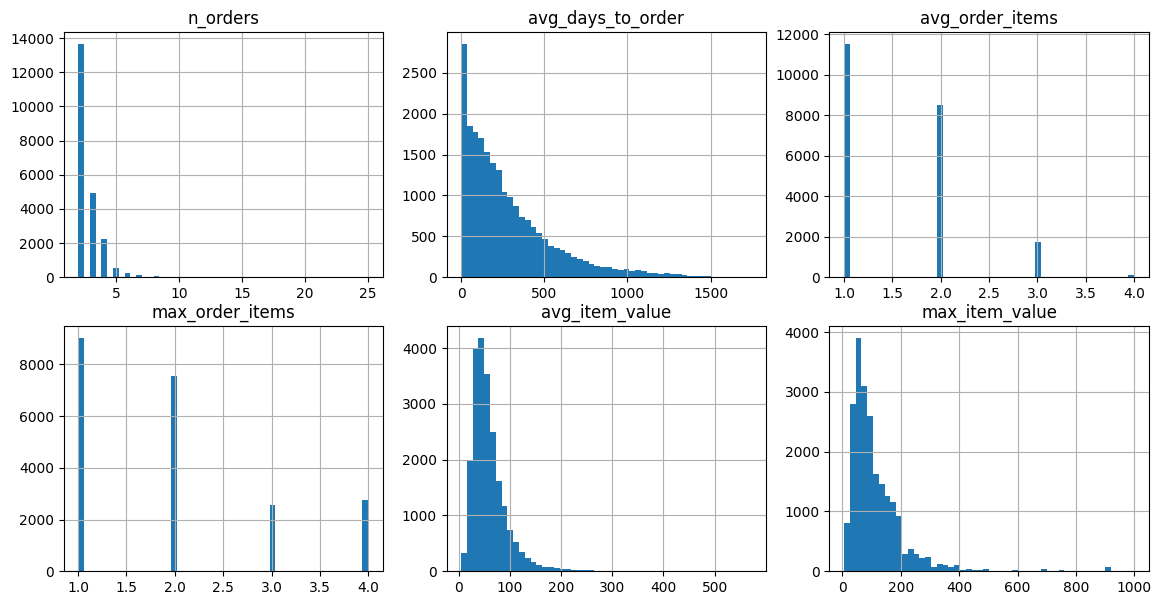

In [13]:
plot_histograms(X, bins=50)

<Axes: xlabel='n_orders', ylabel='avg_days_to_order'>

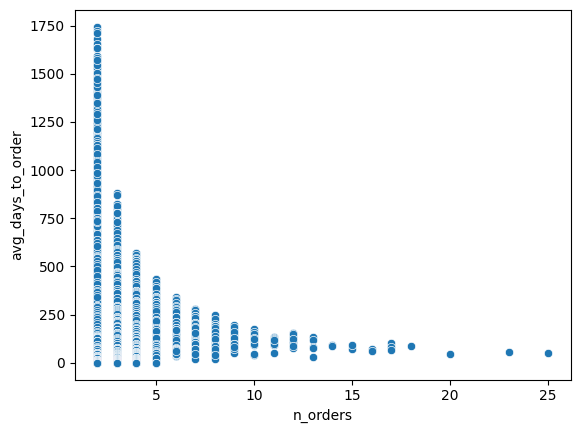

In [14]:
sns.scatterplot(X, x='n_orders', y='avg_days_to_order')

<Axes: xlabel='n_orders', ylabel='std_days_to_order'>

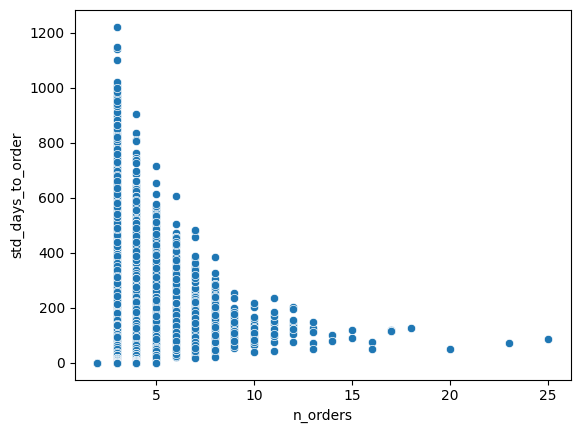

In [15]:
sns.scatterplot(repeat_purchasers, x='n_orders', y='std_days_to_order')

<Axes: xlabel='avg_days_to_order', ylabel='std_days_to_order'>

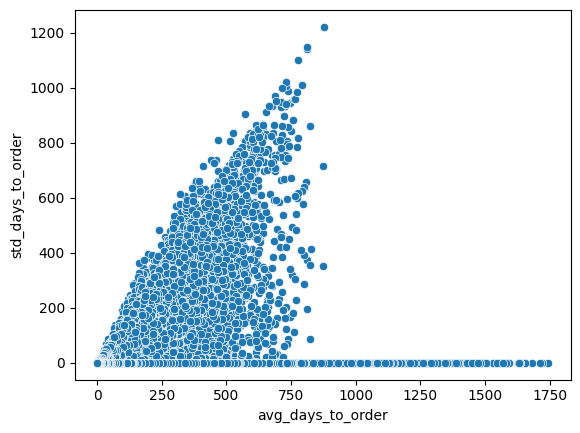

In [16]:
sns.scatterplot(repeat_purchasers, x='avg_days_to_order', y='std_days_to_order')

<Axes: xlabel='n_orders', ylabel='avg_order_items'>

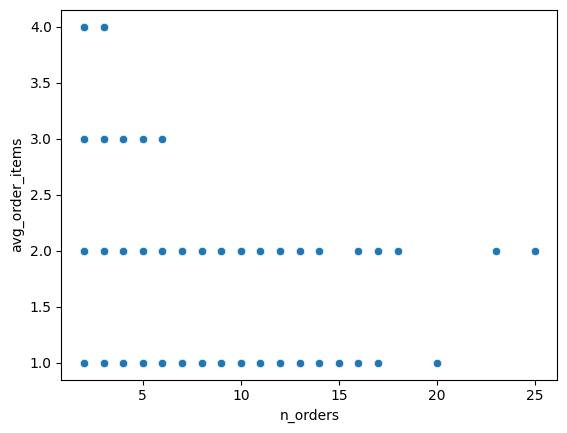

In [17]:
sns.scatterplot(X, x='n_orders', y='avg_order_items')

<Axes: xlabel='n_orders', ylabel='max_order_items'>

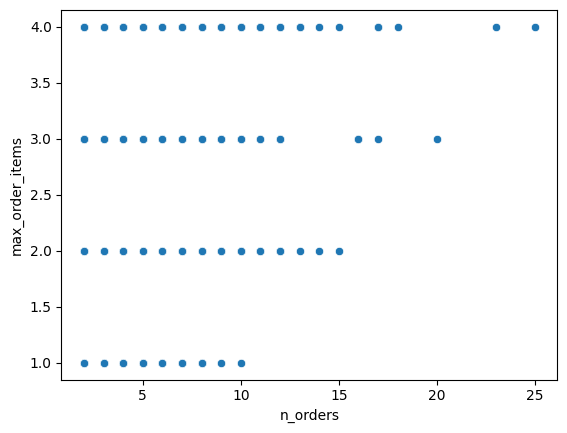

In [18]:
sns.scatterplot(X, x='n_orders', y='max_order_items')

<Axes: xlabel='n_orders', ylabel='avg_item_value'>

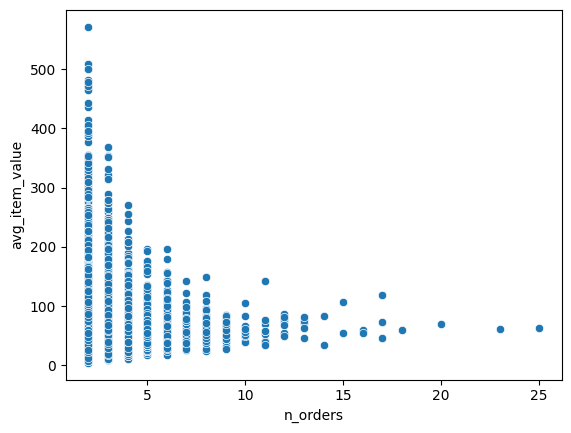

In [19]:
sns.scatterplot(X, x='n_orders', y='avg_item_value')

<Axes: xlabel='n_orders', ylabel='max_item_value'>

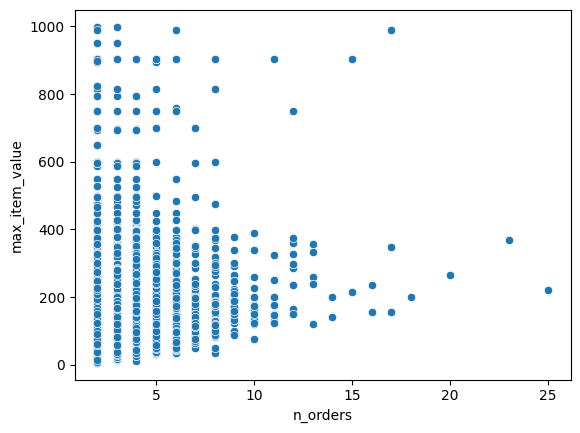

In [20]:
sns.scatterplot(X, x='n_orders', y='max_item_value')

<Axes: xlabel='avg_order_items', ylabel='avg_item_value'>

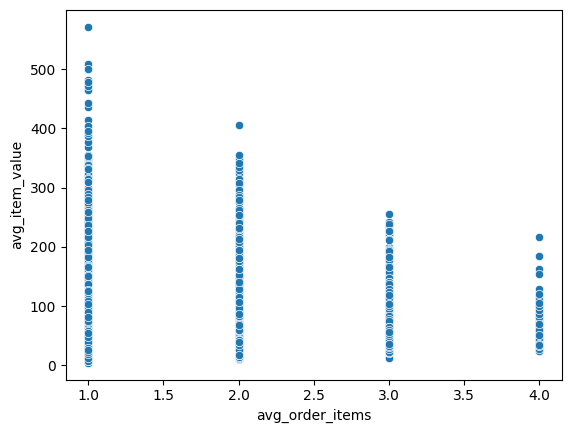

In [21]:
sns.scatterplot(X, x='avg_order_items', y='avg_item_value')

<Axes: xlabel='max_order_items', ylabel='max_item_value'>

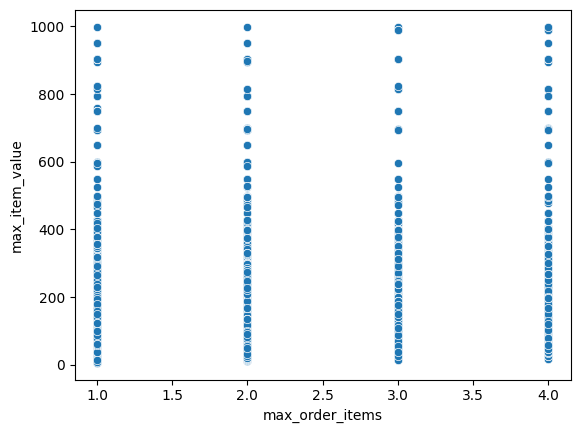

In [22]:
sns.scatterplot(X, x='max_order_items', y='max_item_value')

<Axes: >

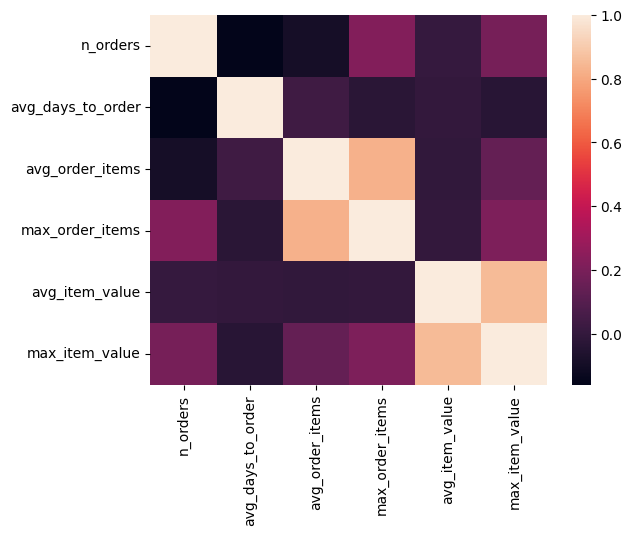

In [23]:
sns.heatmap(X.corr())

# Segmenting Repeat Purchasers by Loyalty & Order Value

In [24]:
def model_results_to_df(results, explode_hyperparams=True):
    df = pd.DataFrame(results)
    if explode_hyperparams:
        df_hyperparams = pd.DataFrame(df['hyperparams'].tolist())
        df = pd.concat([df, df_hyperparams], axis=1)\
                .drop(columns='hyperparams')
    return df

def search_clustering_hyperparams(model_type, hyperparams, X, random_state=None, verbose=True, explode_hyperparams=True):
    results = []
    for hyperparams_iter in hyperparams:
        if random_state:
            hyperparams_iter['random_state'] = random_state
            
        model = model_type(**hyperparams_iter)
        y = model.fit_predict(X)

        silhouette = silhouette_score(X, y)
        inertia = model.inertia_ if model_type == KMeans else None
        results_dict = { 
            'hyperparams': hyperparams_iter, 
            'model': model, 
            'silhouette_score': silhouette,
            'inertia': inertia
        }
        results.append(results_dict)

        if verbose:
            print(hyperparams_iter, f'Silhouette Score: {silhouette}', f'Inertia: {inertia}', sep=' | ')

    df_results = model_results_to_df(results, explode_hyperparams=True)
    
    return df_results

In [25]:
def plot_clusters(X, y, figwidth=15, figheight=10, bins=20):
    X = pd.DataFrame(X) if type(X) != pd.DataFrame else X
    labels = np.unique(y)

    fig, axs = plt.subplots(len(labels), len(X.columns))
    fig.set_figwidth(figwidth)
    fig.set_figheight(figheight)
    fig.suptitle('Cluster Feature Histograms')
    fig.subplots_adjust(wspace=0.3, hspace=0.3)

    col_mins = {}
    col_maxs = {}
    col_means = {}
    for col in X.columns:
        col_mins[col] = X[col].min()
        col_maxs[col] = X[col].max()
        col_means[col] = X[col].mean()

    for i, label in enumerate(labels):
        X_cluster = X.loc[y==label]
        for j, col in enumerate(X.columns):        
            ax = axs[i,j]
            ax.set_xlim(col_mins[col], col_maxs[col])
            if j == 0:
                ax.set_ylabel(label)
            if i == len(labels) - 1:
                ax.set_xlabel(col)
            
            X_cluster[col].hist(ax=ax, bins=bins)
            cluster_col_mean = X_cluster[col].mean()
            ymax = pd.cut(X_cluster[col], bins).value_counts().max()
            ax.vlines(cluster_col_mean, ymin=0, ymax=ymax, color='tab:orange', label='Cluster Mean')
            ax.vlines(col_means[col], ymin=0, ymax=ymax, color='tab:red', label='Sample Mean')

    handles, labels = axs[0,0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')

## Customer Loyalty Segments

In [26]:
X_loyalty = repeat_purchasers[['n_orders', 'avg_days_to_order']]

In [27]:
scaler_loyalty = RobustScaler()
X_loyalty_scaled = scaler_loyalty.fit_transform(X_loyalty)
X_loyalty_scaled

array([[ 0.        ,  1.3322884 ],
       [ 0.        ,  0.15673981],
       [ 3.        ,  0.3354232 ],
       ...,
       [ 0.        , -0.64263323],
       [ 0.        , -0.64263323],
       [ 0.        , -0.64263323]], shape=(21899, 2))

In [28]:
hyperparams = [{'n_clusters': i} for i in range(2, 21)]
kmeans_results_loyalty = search_clustering_hyperparams(KMeans, hyperparams, X_loyalty_scaled, random_state=RANDOM_STATE)

{'n_clusters': 2, 'random_state': 42} | Silhouette Score: 0.5368197754425307 | Inertia: 27329.38858016804
{'n_clusters': 3, 'random_state': 42} | Silhouette Score: 0.5192682961304557 | Inertia: 16731.705888439676
{'n_clusters': 4, 'random_state': 42} | Silhouette Score: 0.5360680742511378 | Inertia: 11654.111462582032
{'n_clusters': 5, 'random_state': 42} | Silhouette Score: 0.5236634858607633 | Inertia: 9071.920113142203
{'n_clusters': 6, 'random_state': 42} | Silhouette Score: 0.5486242970109997 | Inertia: 7583.126133710337
{'n_clusters': 7, 'random_state': 42} | Silhouette Score: 0.5653382445007524 | Inertia: 5429.298703968645
{'n_clusters': 8, 'random_state': 42} | Silhouette Score: 0.5542603406032665 | Inertia: 4575.826565626012
{'n_clusters': 9, 'random_state': 42} | Silhouette Score: 0.5820332641445074 | Inertia: 3760.540070969768
{'n_clusters': 10, 'random_state': 42} | Silhouette Score: 0.5824071660513599 | Inertia: 2929.325932310994
{'n_clusters': 11, 'random_state': 42} | Si

<Axes: title={'center': 'Silhouette Score'}, xlabel='n_clusters'>

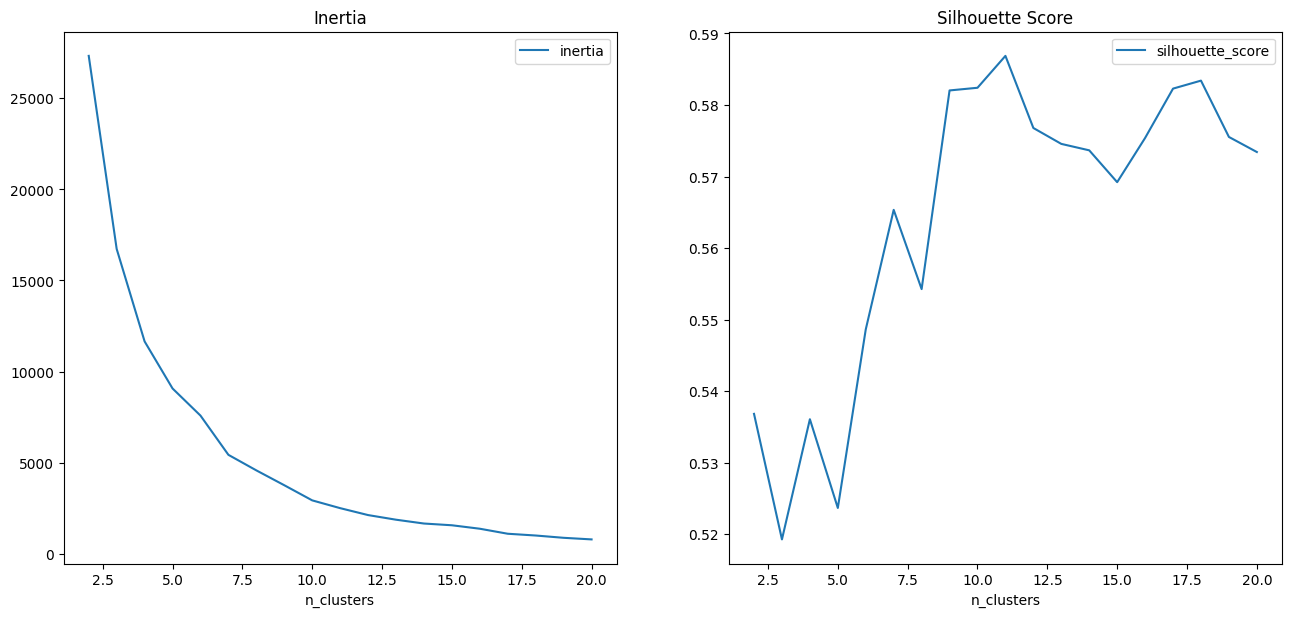

In [29]:
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(14)
fig.set_figheight(7)
plt.tight_layout(pad=5)

axs[0].set_title('Inertia')
kmeans_results_loyalty.plot(x='n_clusters', y='inertia', ax=axs[0])

axs[1].set_title('Silhouette Score')
kmeans_results_loyalty.plot(x='n_clusters', y='silhouette_score', ax=axs[1])

In [30]:
kmeans_loyalty = kmeans_results_loyalty.loc[kmeans_results_loyalty.n_clusters==11, 'model'].iloc[0]
Xy = X.copy()
Xy['segment'] = kmeans_loyalty.labels_
repeat_purchasers['loyalty_segment'] = kmeans_loyalty.labels_

In [31]:
cluster_centers = scaler_loyalty.inverse_transform(kmeans_loyalty.cluster_centers_)
cluster_centers = pd.DataFrame(cluster_centers, columns=['n_orders', 'avg_days_to_order'])
cluster_centers.sort_values(['n_orders', 'avg_days_to_order'])

,n_orders,avg_days_to_order
7,2.000000,79.989519
0,2.000000,337.298646
4,2.000000,1112.120120
8,2.003159,666.537906
6,3.000000,136.723048
2,3.011655,463.849068
5,4.000000,202.135220
1,5.301911,190.968153
10,7.386243,151.624339
3,10.253012,116.361446


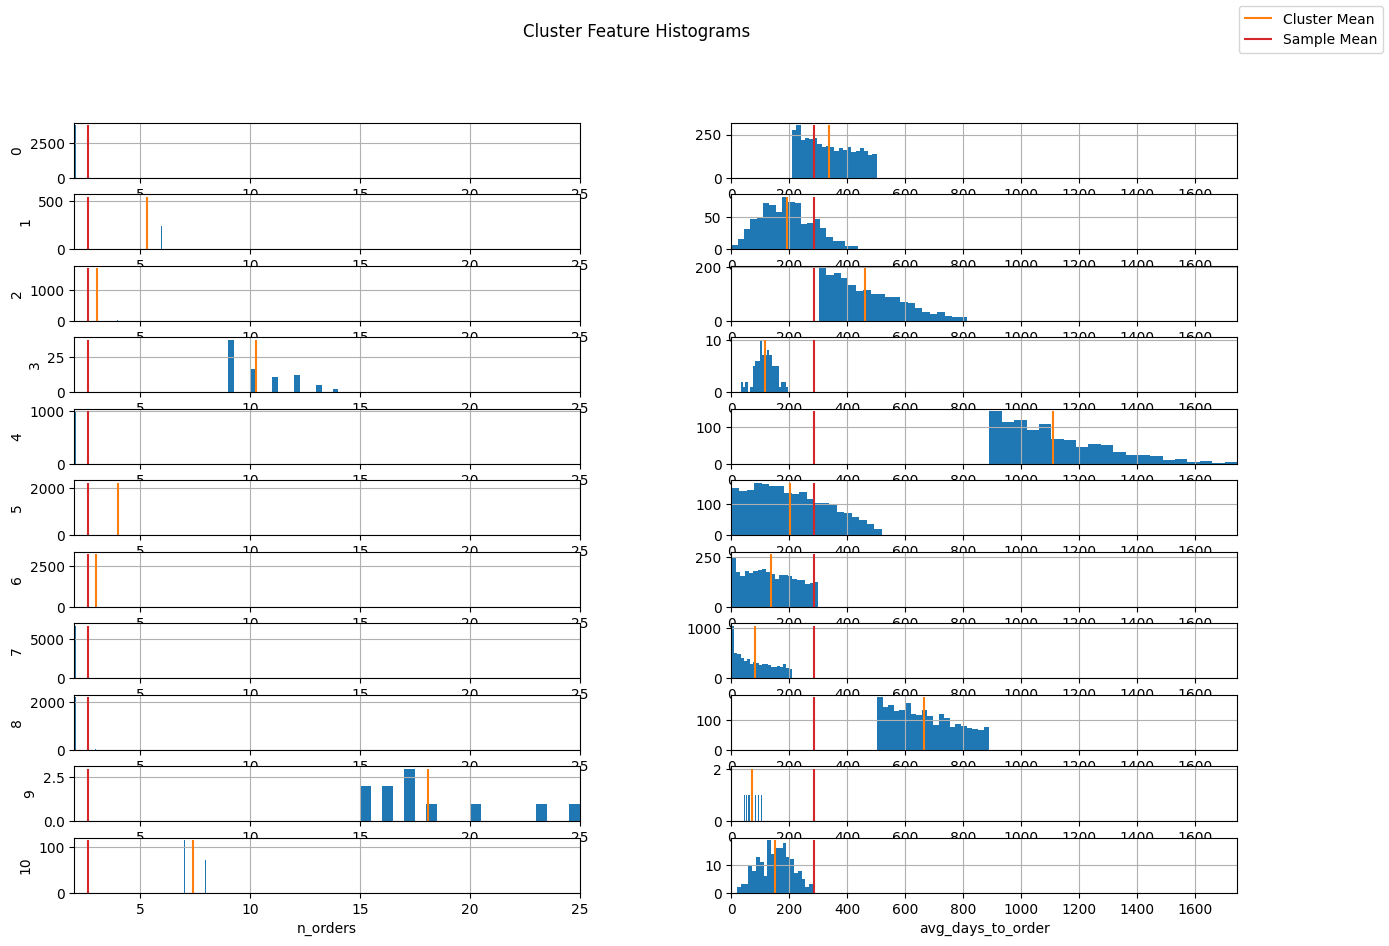

In [32]:
plot_clusters(X_loyalty, kmeans_loyalty.labels_)

<Axes: xlabel='n_orders', ylabel='avg_days_to_order'>

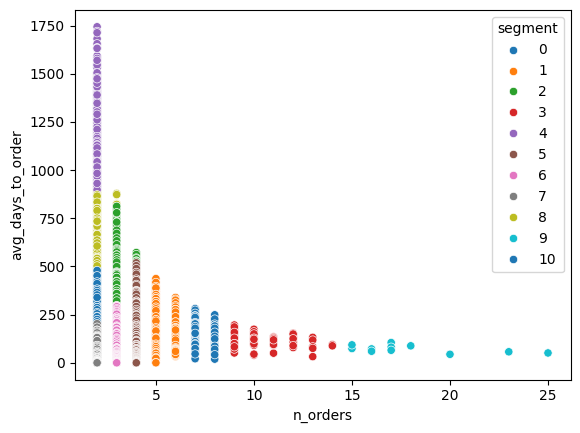

In [33]:
sns.scatterplot(Xy, x='n_orders', y='avg_days_to_order', hue='segment', palette='tab10')

<Axes: xlabel='n_orders', ylabel='std_days_to_order'>

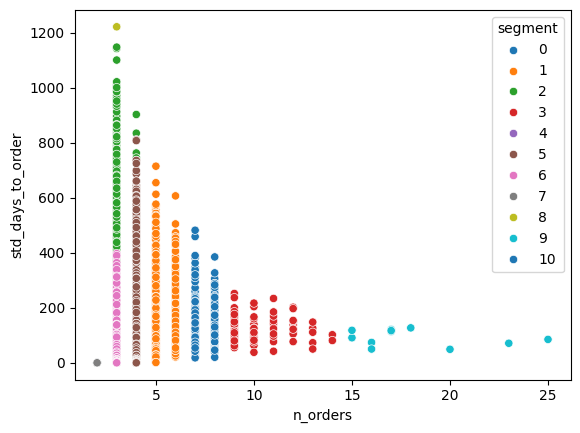

In [34]:
sns.scatterplot(repeat_purchasers, x='n_orders', y='std_days_to_order', hue=Xy.segment, palette='tab10')

/tmp/ipykernel_161787/3953912039.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(repeat_purchasers, x='avg_days_to_order', y='std_days_to_order', hue='segment', palette='tab10')


<Axes: >

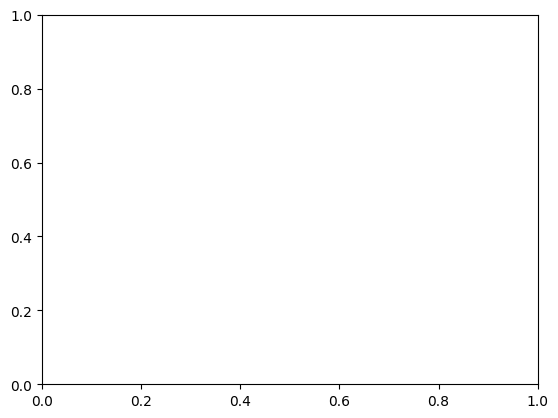

In [35]:
sns.scatterplot(repeat_purchasers, x='avg_days_to_order', y='std_days_to_order', hue=Xy.segment, palette='tab10')

In [36]:
repeat_purchasers.loc[:, ['n_orders', 'avg_days_to_order', 'std_days_to_order']]\
                 .groupby(kmeans_loyalty.labels_)\
                 .describe()\
                 .sort_values([('n_orders', 'mean'), 
                               ('avg_days_to_order', 'mean'), 
                               ('std_days_to_order', 'mean')])\
                 .transpose()

7            0            4            8   \
n_orders          count  6679.000000  3763.000000  1004.000000  2215.000000   
                  mean      2.000000     2.000000     2.000000     2.003160   
                  std       0.000000     0.000000     0.000000     0.056140   
                  min       2.000000     2.000000     2.000000     2.000000   
                  25%       2.000000     2.000000     2.000000     2.000000   
                  50%       2.000000     2.000000     2.000000     2.000000   
                  75%       2.000000     2.000000     2.000000     2.000000   
                  max       2.000000     2.000000     2.000000     3.000000   
avg_days_to_order count  6679.000000  3763.000000  1004.000000  2215.000000   
                  mean     79.989519   337.123572  1111.013944   665.736343   
                  std      62.216987    84.983433   174.814922   108.714647   
                  min       0.000000   209.000000   890.000000   502.000000   
                  25%      23.000000   261.000000   970.000000   572.000000   
                  50%      70.000000   327.000000  1073.000000   651.000000   
                  75%     131.000000   409.000000  1223.250000   750.000000   
                  max     208.000000   501.000000  1744.000000   889.000000   
std_days_to_order count  6679.000000  3763.000000  1004.000000  2215.000000   
                  mean      0.000000     0.000000     0.000000     1.807675   
                  std       0.000000     0.000000     0.000000    37.808855   
                  min       0.000000     0.000000     0.000000     0.000000   
                  25%       0.000000     0.000000     0.000000     0.000000   
                  50%       0.000000     0.000000     0.000000     0.000000   
                  75%       0.000000     0.000000     0.000000     0.000000   
                  max       0.000000     0.000000     0.000000  1222.000000   

                                  6            2            5           1   \
n_orders          count  3213.000000  1731.000000  2226.000000  785.000000   
                  mean      3.000000     3.011554     4.000000    5.301911   
                  std       0.000000     0.106898     0.000000    0.459379   
                  min       3.000000     3.000000     4.000000    5.000000   
                  25%       3.000000     3.000000     4.000000    5.000000   
                  50%       3.000000     3.000000     4.000000    5.000000   
                  75%       3.000000     3.000000     4.000000    6.000000   
                  max       3.000000     4.000000     4.000000    6.000000   
avg_days_to_order count  3213.000000  1731.000000  2226.000000  785.000000   
                  mean    135.956116   462.437897   202.135220  190.968153   
                  std      85.657156   120.201676   129.763034   87.833854   
                  min       0.000000   301.000000     0.000000    0.000000   
                  25%      63.000000   362.500000    94.000000  125.000000   
                  50%     130.000000   437.000000   186.500000  186.000000   
                  75%     206.000000   544.000000   298.750000  251.000000   
                  max     300.000000   812.000000   519.000000  437.000000   
std_days_to_order count  3213.000000  1731.000000  2226.000000  785.000000   
                  mean     98.549953   351.153668   171.821653  187.611465   
                  std      89.029035   224.257474   140.925130  117.844796   
                  min       0.000000     0.000000     0.000000    1.000000   
                  25%      25.000000   167.000000    60.000000   98.000000   
                  50%      74.000000   334.000000   139.000000  168.000000   
                  75%     149.000000   495.000000   246.750000  246.000000   
                  max     412.000000  1148.000000   811.000000  715.000000   

                                 10          3           9   
n_orders          count  189.000000   83.0000

In [37]:
loyalty_segment_map = {
    0: 'New Repeat Customer (Mid Days-to-Order)',
    1: 'Potential Loyal Customers',
    2: 'New Repeat Customer (High Days-to-Order)',
    3: 'Loyal Customer',
    4: 'New Repeat Customer (High Days-to-Order)',
    5: 'Potential Loyal Customers',
    6: 'New Repeat Customer (Low Days-to-Order)',
    7: 'New Repeat Customer (Low Days-to-Order)',
    8: 'New Repeat Customer (High Days-to-Order)',
    9: 'High-Frequency Loyal Customer',
    10: 'Loyal Customer',
}

In [38]:
repeat_purchasers['loyalty_segment'] = Xy.segment.map(loyalty_segment_map)

In [39]:
repeat_purchasers.loyalty_segment.value_counts()

loyalty_segment
New Repeat Customer (Low Days-to-Order)     9892
New Repeat Customer (High Days-to-Order)    4950
New Repeat Customer (Mid Days-to-Order)     3763
Potential Loyal Customers                   3011
Loyal Customer                               272
High-Frequency Loyal Customer                 11
Name: count, dtype: int64

<Axes: xlabel='n_orders', ylabel='avg_days_to_order'>

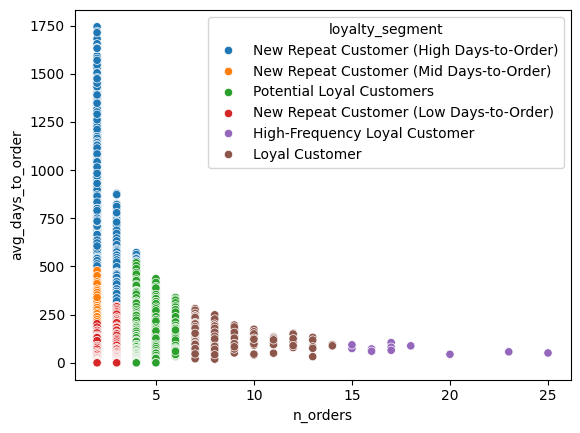

In [40]:
sns.scatterplot(repeat_purchasers, x='n_orders', y='avg_days_to_order', hue='loyalty_segment', palette='tab10')

<Axes: xlabel='n_orders', ylabel='std_days_to_order'>

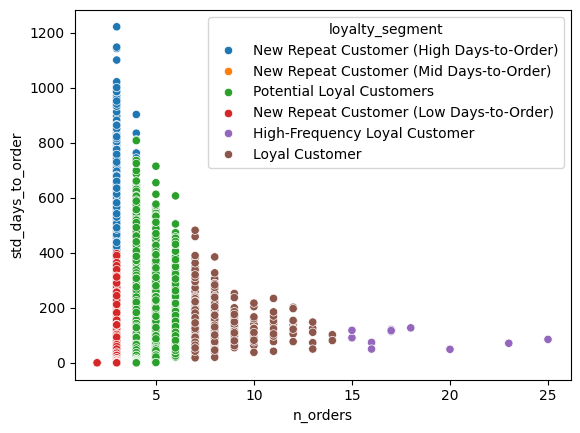

In [41]:
sns.scatterplot(repeat_purchasers, x='n_orders', y='std_days_to_order', hue='loyalty_segment', palette='tab10')

## Order Value

In [42]:
X_order_value = repeat_purchasers[['avg_order_items', 'max_order_items', 'avg_item_value', 'max_item_value']].copy() # Add min / max
X_order_value

,avg_order_items,max_order_items,avg_item_value,max_item_value
1,1.0,1.0,221.500000,399.00
3,1.0,1.0,35.975000,51.96
5,1.0,2.0,49.598571,135.00
8,1.0,2.0,34.620000,52.00
10,2.0,2.0,25.090000,34.99
...,...,...,...,...
83996,2.0,3.0,67.798333,239.00
83998,2.0,4.0,40.238571,59.50
84005,2.0,2.0,107.663333,228.00
84006,1.0,1.0,82.555000,149.03


In [43]:
scaler_order_value = RobustScaler()
X_order_value_scaled = scaler_order_value.fit_transform(X_order_value)
X_order_value_scaled

array([[ 0.        , -1.        ,  4.75511156,  3.33387097],
       [ 0.        , -1.        , -0.42495991, -0.39774194],
       [ 0.        ,  0.        , -0.04457412,  0.49516129],
       ...,
       [ 1.        ,  0.        ,  1.57666084,  1.49516129],
       [ 0.        , -1.        ,  0.87560729,  0.64602151],
       [ 1.        ,  0.        ,  0.99615685,  2.00053763]],
      shape=(21899, 4))

In [44]:
pca_order_value = PCA(n_components='mle')
X_order_value_pca = pca_order_value.fit_transform(X_order_value_scaled)
X_order_value_pca

array([[ 4.94676201, -2.38829037,  0.82121947],
       [-1.16915598, -0.86512445, -0.13908157],
       [-0.08743691, -0.18151313, -0.55029769],
       ...,
       [ 1.80775783, -0.15384753,  0.26601495],
       [ 0.44253878, -1.25324835,  0.03371269],
       [ 1.78061964, -0.03242219, -0.43196754]], shape=(21899, 3))

In [45]:
hyperparams = [{'n_clusters': i} for i in range(2, 21)]
kmeans_results_order_value = search_clustering_hyperparams(KMeans, hyperparams, X_order_value_pca, random_state=RANDOM_STATE)

{'n_clusters': 2, 'random_state': 42} | Silhouette Score: 0.4124822369309452 | Inertia: 54678.93918325128
{'n_clusters': 3, 'random_state': 42} | Silhouette Score: 0.3926635878275079 | Inertia: 36592.48229348537
{'n_clusters': 4, 'random_state': 42} | Silhouette Score: 0.44403642822033573 | Inertia: 26005.24410539239
{'n_clusters': 5, 'random_state': 42} | Silhouette Score: 0.4082232969555365 | Inertia: 20700.98207309721
{'n_clusters': 6, 'random_state': 42} | Silhouette Score: 0.4135984226137063 | Inertia: 17142.063653231642
{'n_clusters': 7, 'random_state': 42} | Silhouette Score: 0.4219364712627244 | Inertia: 15213.410469421917
{'n_clusters': 8, 'random_state': 42} | Silhouette Score: 0.4286610573730243 | Inertia: 13054.93517961913
{'n_clusters': 9, 'random_state': 42} | Silhouette Score: 0.4106314997901801 | Inertia: 11836.20687663992
{'n_clusters': 10, 'random_state': 42} | Silhouette Score: 0.41064595696148604 | Inertia: 10756.921562262218
{'n_clusters': 11, 'random_state': 42} |

<Axes: title={'center': 'Silhouette Score'}, xlabel='n_clusters'>

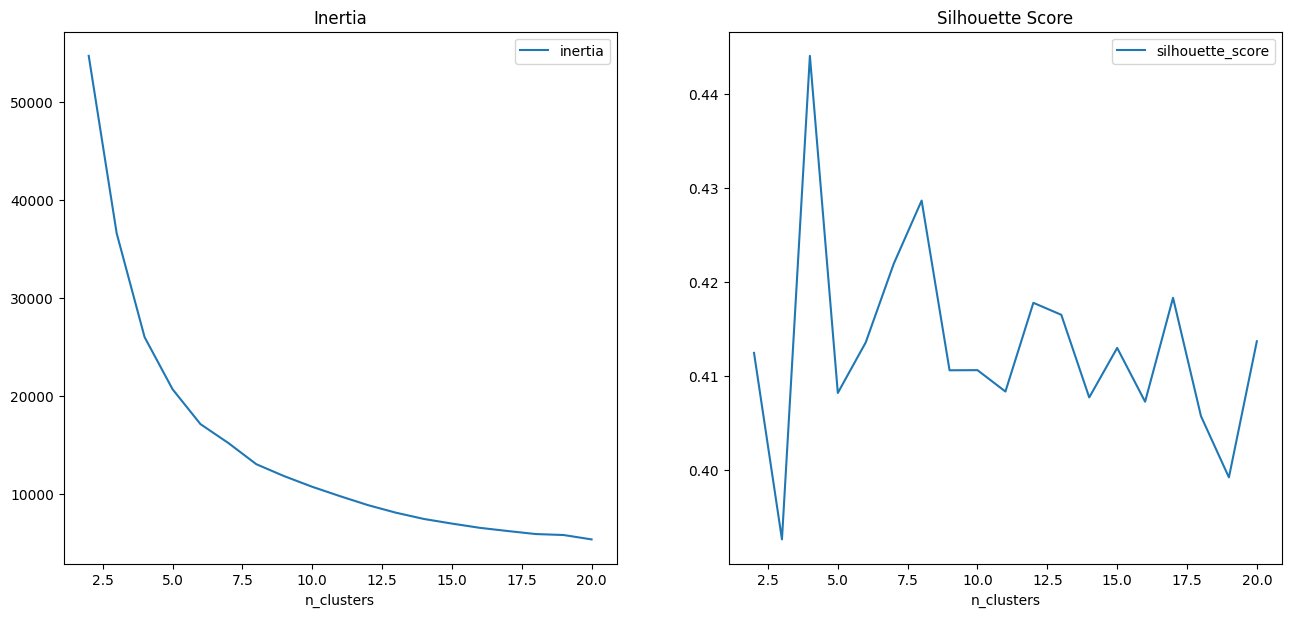

In [46]:
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(14)
fig.set_figheight(7)
plt.tight_layout(pad=5)

axs[0].set_title('Inertia')
kmeans_results_order_value.plot(x='n_clusters', y='inertia', ax=axs[0])

axs[1].set_title('Silhouette Score')
kmeans_results_order_value.plot(x='n_clusters', y='silhouette_score', ax=axs[1])

In [47]:
kmeans_order_value = kmeans_results_order_value.loc[kmeans_results_order_value.n_clusters==4, 'model'].iloc[0]
Xy = X_order_value.copy()
Xy['segment'] = kmeans_order_value.labels_
repeat_purchasers['segment'] = kmeans_order_value.labels_

In [48]:
Xy['segment'].value_counts()

segment
0    12617
1     4891
2     4102
3      289
Name: count, dtype: int64

In [49]:
cluster_centers = pca_order_value.inverse_transform(kmeans_order_value.cluster_centers_)
cluster_centers = scaler_order_value.inverse_transform(cluster_centers)
cluster_centers = pd.DataFrame(cluster_centers, columns=['avg_order_items', 'max_order_items', 'avg_item_value', 'max_item_value'])
cluster_centers.sort_values(['avg_order_items', 'max_order_items', 'avg_item_value', 'max_item_value'])

,avg_order_items,max_order_items,avg_item_value,max_item_value
0,1.265688,1.471386,43.772173,67.645303
3,1.364521,2.288453,245.570599,678.455930
2,1.398368,1.621263,103.227470,206.364717
1,2.478127,3.469931,53.397854,129.372084


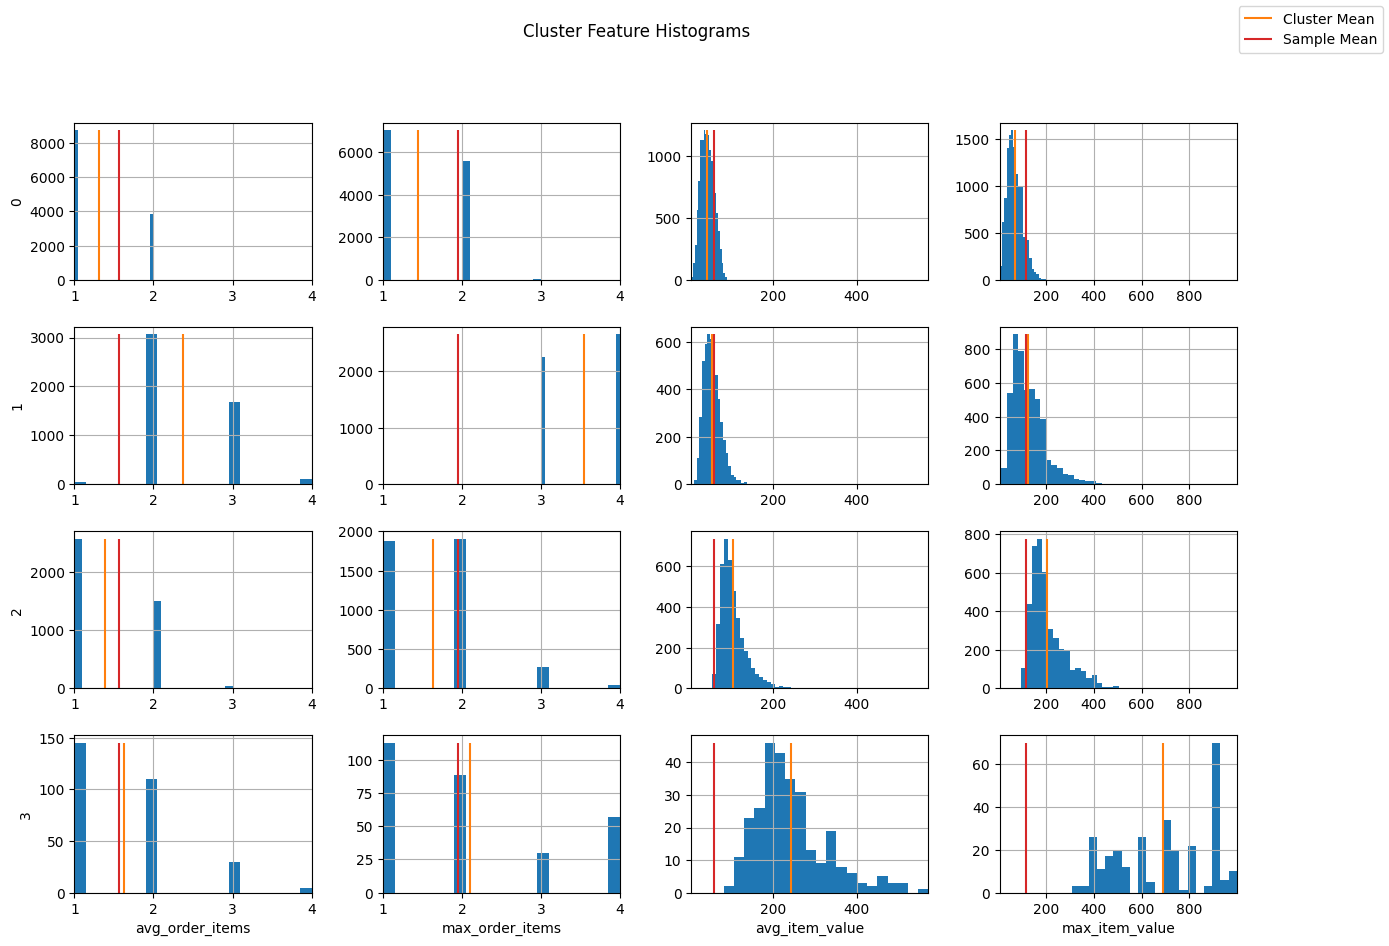

In [50]:
plot_clusters(X_order_value, kmeans_order_value.labels_)

<Axes: xlabel='avg_order_items', ylabel='avg_item_value'>

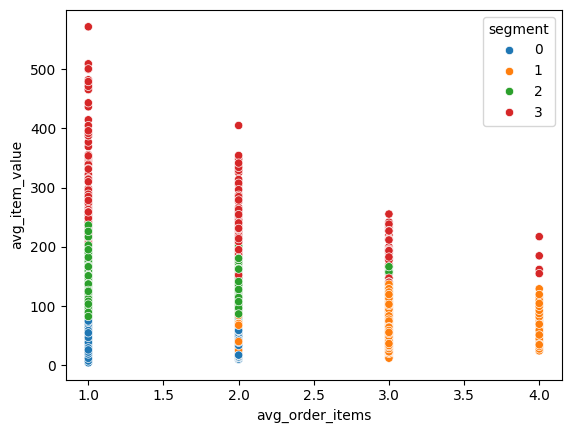

In [51]:
sns.scatterplot(Xy, x='avg_order_items', y='avg_item_value', hue='segment', palette='tab10')

<Axes: xlabel='avg_order_items', ylabel='max_item_value'>

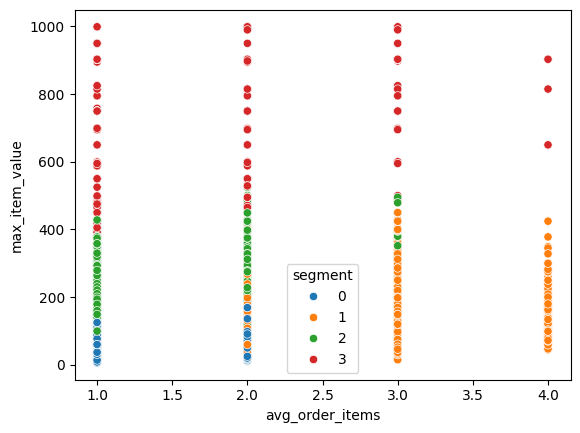

In [52]:
sns.scatterplot(Xy, x='avg_order_items', y='max_item_value', hue='segment', palette='tab10')

<Axes: xlabel='max_order_items', ylabel='avg_item_value'>

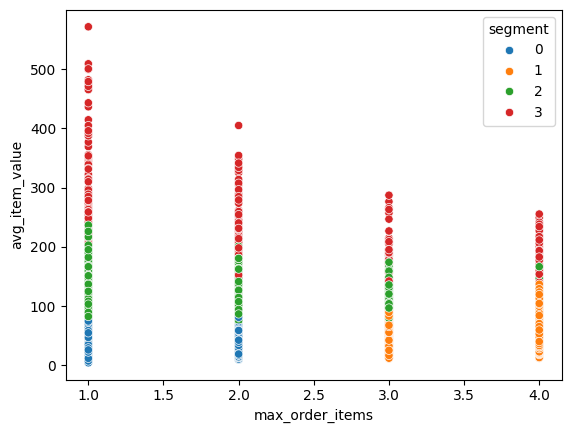

In [53]:
sns.scatterplot(Xy, x='max_order_items', y='avg_item_value', hue='segment', palette='tab10')

<Axes: xlabel='max_order_items', ylabel='max_item_value'>

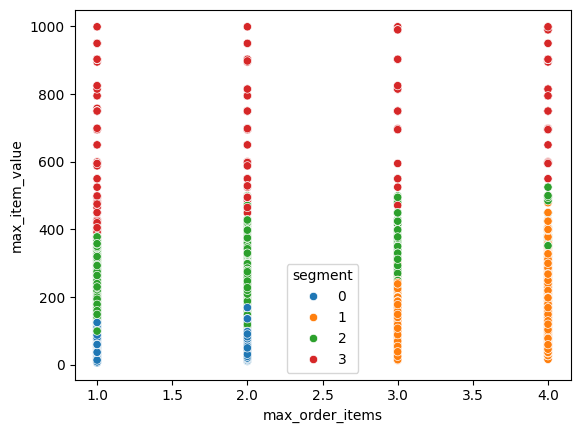

In [54]:
sns.scatterplot(Xy, x='max_order_items', y='max_item_value', hue='segment', palette='tab10')

<Axes: xlabel='avg_item_value', ylabel='max_item_value'>

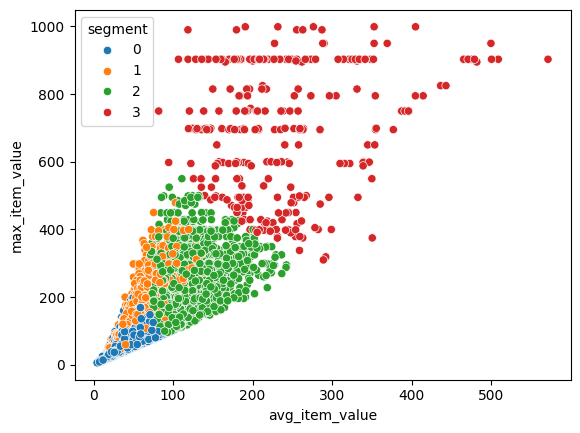

In [55]:
sns.scatterplot(Xy, x='avg_item_value', y='max_item_value', hue='segment', palette='tab10')

<Axes: xlabel='n_orders', ylabel='avg_item_value'>

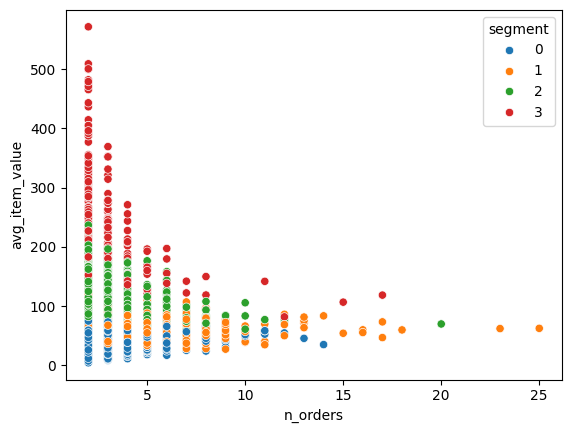

In [56]:
sns.scatterplot(repeat_purchasers, x='n_orders', y='avg_item_value', hue='segment', palette='tab10')

<Axes: xlabel='n_orders', ylabel='max_item_value'>

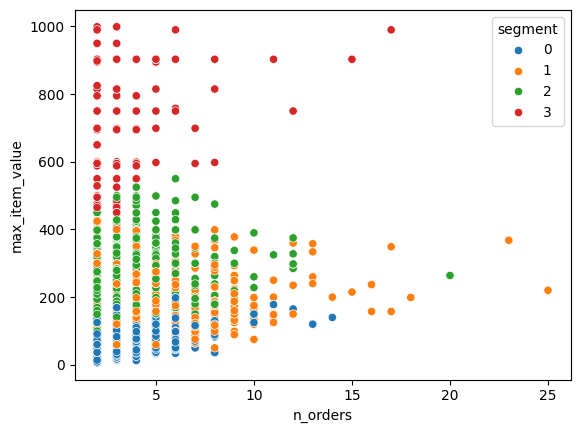

In [57]:
sns.scatterplot(repeat_purchasers, x='n_orders', y='max_item_value', hue='segment', palette='tab10')

<Axes: xlabel='n_orders', ylabel='avg_order_items'>

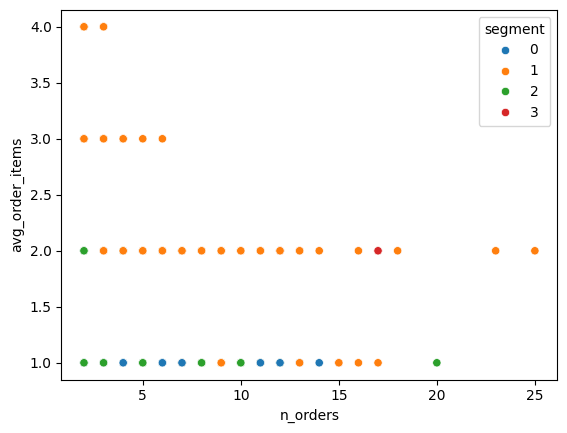

In [58]:
sns.scatterplot(repeat_purchasers, x='n_orders', y='avg_order_items', hue='segment', palette='tab10')

<Axes: xlabel='n_orders', ylabel='max_order_items'>

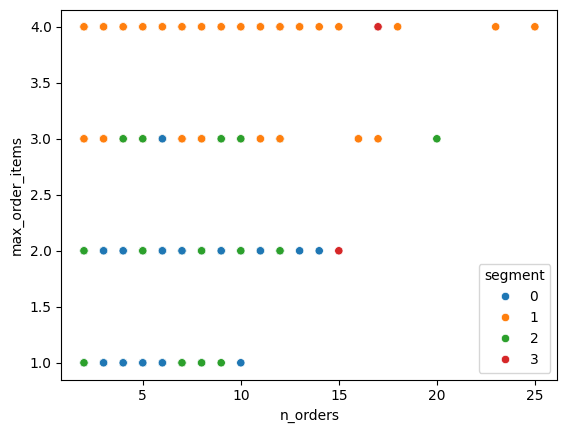

In [59]:
sns.scatterplot(repeat_purchasers, x='n_orders', y='max_order_items', hue='segment', palette='tab10')

In [60]:
order_value_segment_map = {
    0: 'Ordering Low Value',
    1: 'Ordering Multiple Mid-Value Items',
    2: 'Ordering Mid-/High-Value Items',
    3: 'Ordering High Value Items'
}

In [61]:
repeat_purchasers['order_value_segment'] = Xy['segment'].map(order_value_segment_map) 

# Segmenting Active Purchasers by Categorical Choice

In [62]:
order_items_query = """
SELECT ue.id, oi.*
FROM users_enriched ue,
LATERAL UNNEST(ue.order_items::order_item[]) AS oi;
"""
order_items = read_query(order_items_query)
order_items.head()


SELECT ue.id, oi.*
FROM users_enriched ue,
LATERAL UNNEST(ue.order_items::order_item[]) AS oi;
 



,id,order_id,product_name,department,category,brand,sale_price,created_at
0,56219,70373,WranglerÂ® Booty Up Stretch Jean for Women,Women,Jeans,Wrangler,74.99,2021-05-27 23:07:12
1,9418,90353,Colleen Skirt Slip,Women,Intimates,Yummie Tummie,44.00,2021-07-30 12:35:12
2,9418,90352,Barbour Ladies Utility Jacket,Women,Outerwear & Coats,Barbour,399.00,2023-04-21 14:50:59
3,21731,27173,Modadorn New Arrivals Spring & fall Star Light...,Women,Accessories,Modadorn,12.99,2023-09-17 22:23:37
4,21731,27173,Patty Women Sexy Cross Back Necklace Hippie To...,Women,Tops & Tees,Patty,32.99,2023-09-20 00:58:50


In [122]:
X_category = order_items[['id', 'category', 'order_id']].pivot_table(index='id', columns='category', aggfunc='count', fill_value=0)
X_category.head()

order_id                                                 \
category Accessories Active Blazers & Jackets Clothing Sets Dresses   
id                                                                    
1                  0      1                 1             0       0   
2                  0      0                 0             0       0   
3                  0      1                 0             0       0   
6                  1      1                 0             0       0   
7                  0      0                 0             0       0   

                                                                            \
category Fashion Hoodies & Sweatshirts Intimates Jeans Jumpsuits & Rompers   
id                                                                           
1                                    0         0     1                   0   
2                                    0         0     0                   0   
3                                    0         0     1                   0   
6                                    2         0     3                   0   
7                                    0         0     0                   0   

                   ...                                                    \
category Leggings  ... Skirts Sleep & Lounge Socks Socks & Hosiery Suits   
id                 ...                                                     
1               0  ...      0              0     0               0     0   
2               0  ...      0              0     0               0     0   
3               0  ...      0              1     0               0     0   
6               0  ...      0              2     2               0     0   
7               0  ...      0              0     0               0     0   

                                                                  
category Suits & Sport Coats Sweaters Swim Tops & Tees Underwear  
id                                                                
1                          0        0    0           0         0  
2                          0        0    0           0         1  
3                          0        0    1           0         0  
6                          1        2    0           1         3  
7                          1        0    0           0         0  

[5 rows x 26 columns]

In [123]:
X_category.describe().T

count      mean       std  min  25%  \
         category                                                               
order_id Accessories                    58293.0  0.124835  0.360237  0.0  0.0   
         Active                         58293.0  0.116618  0.346761  0.0  0.0   
         Blazers & Jackets              58293.0  0.041566  0.208344  0.0  0.0   
         Clothing Sets                  58293.0  0.002728  0.052809  0.0  0.0   
         Dresses                        58293.0  0.070420  0.276294  0.0  0.0   
         Fashion Hoodies & Sweatshirts  58293.0  0.153003  0.399864  0.0  0.0   
         Intimates                      58293.0  0.173246  0.457959  0.0  0.0   
         Jeans                          58293.0  0.163279  0.415384  0.0  0.0   
         Jumpsuits & Rompers            58293.0  0.011923  0.109639  0.0  0.0   
         Leggings                       58293.0  0.041086  0.207779  0.0  0.0   
         Maternity                      58293.0  0.066492  0.267472  0.0  0.0   
         Outerwear & Coats              58293.0  0.115365  0.347205  0.0  0.0   
         Pants                          58293.0  0.094094  0.328617  0.0  0.0   
         Pants & Capris                 58293.0  0.043590  0.214028  0.0  0.0   
         Plus                           58293.0  0.055633  0.244004  0.0  0.0   
         Shorts                         58293.0  0.141509  0.384406  0.0  0.0   
         Skirts                         58293.0  0.027773  0.168551  0.0  0.0   
         Sleep & Lounge                 58293.0  0.143516  0.385334  0.0  0.0   
         Socks                          58293.0  0.081811  0.304950  0.0  0.0   
         Socks & Hosiery                58293.0  0.049011  0.227274  0.0  0.0   
         Suits                          58293.0  0.013020  0.114717  0.0  0.0   
         Suits & Sport Coats            58293.0  0.066886  0.271038  0.0  0.0   
         Sweaters                       58293.0  0.145300  0.388658  0.0  0.0   
         Swim                           58293.0  0.146913  0.391046  0.0  0.0   
         Tops & Tees                    58293.0  0.153792  0.402086  0.0  0.0   
         Underwear                      58293.0  0.097130  0.338166  0.0  0.0   

                                        50%  75%  max  
         category                                      
order_id Accessories                    0.0  0.0  7.0  
         Active                         0.0  0.0  5.0  
         Blazers & Jackets              0.0  0.0  3.0  
         Clothing Sets                  0.0  0.0  2.0  
         Dresses                        0.0  0.0  4.0  
         Fashion Hoodies & Sweatshirts  0.0  0.0  4.0  
         Intimates                      0.0  0.0  8.0  
         Jeans                          0.0  0.0  7.0  
         Jumpsuits & Rompers            0.0  0.0  2.0  
         Leggings                       0.0  0.0  3.0  
         Maternity                      0.0  0.0  4.0  
         Outerwear & Coats              0.0  0.0  4.0  
         Pants                          0.0  0.0  6.0  
         Pants & Capris                 0.0  0.0  3.0  
         Plus                           0.0  0.0  4.0  
         Shorts                         0.0  0.0  5.0  
         Skirts                         0.0  0.0  2.0  
         Sleep & Lounge                 0.0  0.0  5.0  
         Socks                          0.0  0.0  5.0  
         Socks & Hosiery                0.0  0.0  3.0  
         Suits                          0.0  0.0  2.0  
         Suits & Sport Coats            0.0  0.0  4.0  
         Sweaters                       0.0  0.0  5.0  
         Swim                           0.0  0.0  5.0  
         Tops & Tees                    0.0  0.0  5.0  
         Underwear                      0.0  0.0  5.0

<Axes: xlabel='None-category', ylabel='None-category'>

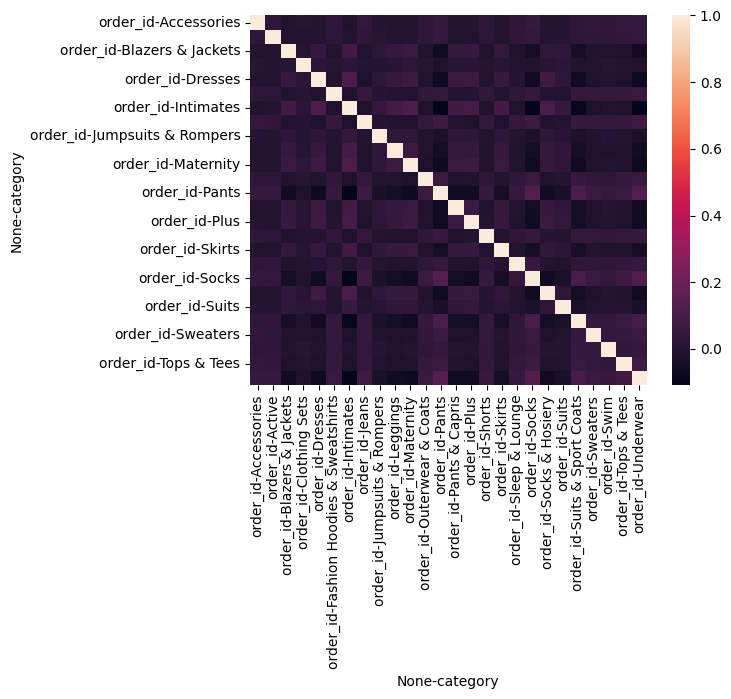

In [124]:
sns.heatmap(X_category.corr())

In [226]:
cat_counts = X_category.sum().sort_values(ascending=False).to_frame().reset_index().drop(columns='level_0')
cat_counts

,category,0
0,Intimates,10099
1,Jeans,9518
2,Tops & Tees,8965
3,Fashion Hoodies & Sweatshirts,8919
4,Swim,8564
5,Sweaters,8470
6,Sleep & Lounge,8366
7,Shorts,8249
8,Accessories,7277
9,Active,6798


<Axes: xlabel='category'>

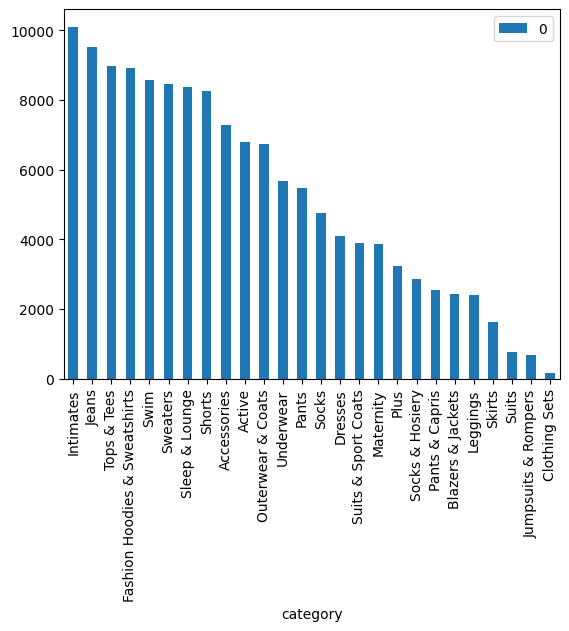

In [227]:
cat_counts.plot(x='category', y=0, kind='bar')

In [294]:
scaler_category = MinMaxScaler()
X_category_scaled = scaler_category.fit_transform(X_category)
X_category_scaled

array([[0.        , 0.2       , 0.33333333, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.2       ],
       [0.        , 0.2       , 0.        , ..., 0.2       , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.14285714, 0.2       , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], shape=(58293, 26))

In [295]:
pca_category = PCA(n_components='mle')
X_category_pca = pca_category.fit_transform(X_category_scaled)
X_category_pca

array([[-0.05818214,  0.02453515, -0.00655712, ..., -0.02588826,
        -0.03527972, -0.01145991],
       [-0.02615471, -0.04914704, -0.06243818, ...,  0.00619022,
        -0.02812196, -0.00838518],
       [ 0.03383513, -0.09335358,  0.00474194, ..., -0.04371171,
         0.10027294, -0.07002866],
       ...,
       [-0.14035076,  0.22086497,  0.22276506, ...,  0.19130258,
         0.05441367, -0.02601235],
       [ 0.00814781, -0.0766749 , -0.02115292, ...,  0.02455093,
        -0.01184234,  0.12195177],
       [-0.04057105, -0.02568018, -0.03509286, ..., -0.0106317 ,
        -0.01662112, -0.00601724]], shape=(58293, 25))

In [296]:
pca_category.explained_variance_ratio_

array([0.08495823, 0.07016936, 0.06032635, 0.05406939, 0.05031103,
       0.04839691, 0.04638137, 0.04612842, 0.04535242, 0.04162107,
       0.03827196, 0.0379478 , 0.03627994, 0.03609418, 0.03476883,
       0.03328285, 0.0326476 , 0.02853527, 0.02770059, 0.02654862,
       0.02574999, 0.02376843, 0.02312538, 0.02144306, 0.02058413])

In [307]:
pca_category = PCA(n_components=17)
X_category_pca = pca_category.fit_transform(X_category_scaled)
X_category_pca

array([[-0.05818214,  0.02453515, -0.00655712, ..., -0.00040791,
        -0.07022586, -0.01388007],
       [-0.02615471, -0.04914704, -0.06243818, ...,  0.04672817,
        -0.01610013,  0.14338437],
       [ 0.03383513, -0.09335358,  0.00474194, ..., -0.05924097,
        -0.03076655, -0.0189254 ],
       ...,
       [-0.14035076,  0.22086497,  0.22276506, ..., -0.02176721,
        -0.01103754, -0.00984307],
       [ 0.00814781, -0.0766749 , -0.02115292, ..., -0.04048872,
        -0.02169185, -0.01850908],
       [-0.04057105, -0.02568018, -0.03509286, ..., -0.02954389,
        -0.01063626, -0.01856671]], shape=(58293, 17))

In [308]:
sum(pca_category.explained_variance_ratio_)

np.float64(0.7970076917383414)

In [309]:
hyperparams = [{'n_clusters': i} for i in range(2, 21)]
kmeans_results_category = search_clustering_hyperparams(KMeans, hyperparams, X_category_pca, random_state=RANDOM_STATE)

{'n_clusters': 2, 'random_state': 42} | Silhouette Score: 0.2986432118156186 | Inertia: 5559.78851870713
{'n_clusters': 3, 'random_state': 42} | Silhouette Score: 0.23200318976809023 | Inertia: 5329.194050350345
{'n_clusters': 4, 'random_state': 42} | Silhouette Score: 0.187497314939728 | Inertia: 5089.762371224215
{'n_clusters': 5, 'random_state': 42} | Silhouette Score: 0.19364148174416868 | Inertia: 4638.681908464916
{'n_clusters': 6, 'random_state': 42} | Silhouette Score: 0.2039289437576645 | Inertia: 4416.058220239652
{'n_clusters': 7, 'random_state': 42} | Silhouette Score: 0.21681244061809604 | Inertia: 4189.142382529693
{'n_clusters': 8, 'random_state': 42} | Silhouette Score: 0.16313161971385018 | Inertia: 3965.1220462757697
{'n_clusters': 9, 'random_state': 42} | Silhouette Score: 0.23768552578520155 | Inertia: 3719.375818241585
{'n_clusters': 10, 'random_state': 42} | Silhouette Score: 0.25604029799101036 | Inertia: 3368.6038267002396
{'n_clusters': 11, 'random_state': 42} 

<Axes: title={'center': 'Silhouette Score'}, xlabel='n_clusters'>

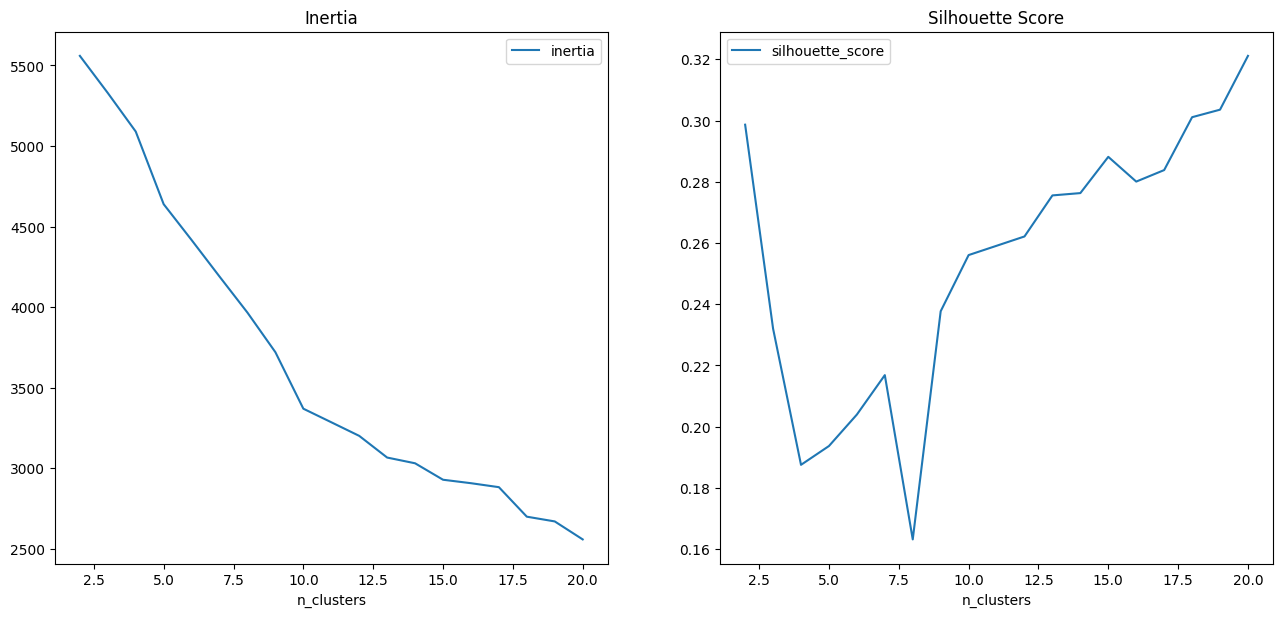

In [310]:
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(14)
fig.set_figheight(7)
plt.tight_layout(pad=5)

axs[0].set_title('Inertia')
kmeans_results_category.plot(x='n_clusters', y='inertia', ax=axs[0])

axs[1].set_title('Silhouette Score')
kmeans_results_category.plot(x='n_clusters', y='silhouette_score', ax=axs[1])

In [311]:
kmeans_category = kmeans_results_category.loc[kmeans_results_category.n_clusters==10, 'model'].iloc[0]
Xy = X_category.copy()
Xy['segment'] = kmeans_category.labels_

In [329]:
Xy.segment.value_counts()

segment
8    23504
4     6395
5     4868
3     4701
1     4473
2     4176
7     3177
0     2918
6     2518
9     1563
Name: count, dtype: int64

In [337]:
columns = X_category.droplevel(0, axis=1).columns.tolist()
cluster_centers = pca_category.inverse_transform(kmeans_category.cluster_centers_)
cluster_centers = scaler_category.inverse_transform(cluster_centers)
cluster_centers = pd.DataFrame(cluster_centers, columns=columns)
cluster_centers.T

,0,1,2,3,4,5,6,7,8,9
Accessories,0.133246,0.144089,0.129825,0.143065,0.138929,0.130767,0.129072,0.179867,0.104225,0.100965
Active,0.099352,0.107259,0.100145,0.105368,0.113439,0.105087,0.108136,0.133280,0.128871,0.097935
Blazers & Jackets,0.073439,0.030668,0.028028,0.020848,0.031231,0.029079,0.066094,0.009259,0.050469,0.085183
Clothing Sets,0.008150,0.003565,0.003229,0.002058,0.003113,0.001674,0.005283,-0.000401,0.002100,0.004269
Dresses,0.101817,0.047960,0.045330,0.038333,0.054326,0.049536,0.149583,0.021309,0.083243,0.149985
Fashion Hoodies & Sweatshirts,0.110260,0.017002,0.024008,0.025108,1.116402,0.019704,0.122279,0.163658,0.001081,0.137149
Intimates,0.499127,0.135980,0.148378,0.141041,0.145718,0.137228,0.471137,-0.095534,0.151611,0.451365
Jeans,0.166546,0.176860,0.165966,0.171986,0.183279,0.179767,0.152493,0.297681,0.134860,0.123292
Jumpsuits & Rompers,0.027953,0.008900,0.014491,0.010375,0.011513,0.007200,0.031695,-0.008481,0.010410,0.037189
Leggings,0.075980,0.027312,0.026226,0.022819,0.029341,0.028663,0.075612,0.007867,0.048450,0.097888


In [345]:
Xy.groupby('segment').min().T

segment                                 0  1  2  3  4  5  6  7  8  9
         category                                                   
order_id Accessories                    0  0  0  0  0  0  0  0  0  0
         Active                         0  0  0  0  0  0  0  0  0  0
         Blazers & Jackets              0  0  0  0  0  0  0  0  0  0
         Clothing Sets                  0  0  0  0  0  0  0  0  0  0
         Dresses                        0  0  0  0  0  0  0  0  0  0
         Fashion Hoodies & Sweatshirts  0  0  0  0  1  0  0  0  0  0
         Intimates                      0  0  0  0  0  0  0  0  0  0
         Jeans                          0  0  0  0  0  0  0  0  0  0
         Jumpsuits & Rompers            0  0  0  0  0  0  0  0  0  0
         Leggings                       0  0  0  0  0  0  0  0  0  0
         Maternity                      1  0  0  0  0  0  0  0  0  0
         Outerwear & Coats              0  1  0  0  0  0  0  0  0  0
         Pants                          0  0  0  0  0  0  0  0  0  0
         Pants & Capris                 0  0  0  0  0  0  0  0  0  0
         Plus                           0  0  0  0  0  0  0  0  0  0
         Shorts                         0  0  0  0  0  1  0  0  0  0
         Skirts                         0  0  0  0  0  0  0  0  0  1
         Sleep & Lounge                 0  0  0  0  0  0  0  0  0  0
         Socks                          0  0  0  0  0  0  0  0  0  0
         Socks & Hosiery                0  0  0  0  0  0  1  0  0  0
         Suits                          0  0  0  0  0  0  0  0  0  0
         Suits & Sport Coats            0  0  0  0  0  0  0  0  0  0
         Sweaters                       0  0  0  0  0  0  0  0  0  0
         Swim                           0  0  1  0  0  0  0  0  0  0
         Tops & Tees                    0  0  0  1  0  0  0  0  0  0
         Underwear                      0  0  0  0  0  0  0  0  0  0

In [343]:
Xy.groupby('segment').mean().T

segment                                        0         1         2  \
         category                                                      
order_id Accessories                    0.105209  0.125643  0.108956   
         Active                         0.101097  0.109770  0.102730   
         Blazers & Jackets              0.086018  0.031522  0.029454   
         Clothing Sets                  0.005826  0.003801  0.001916   
         Dresses                        0.128855  0.049631  0.047893   
         Fashion Hoodies & Sweatshirts  0.112063  0.017662  0.024665   
         Intimates                      0.341330  0.111782  0.113266   
         Jeans                          0.124400  0.156942  0.142481   
         Jumpsuits & Rompers            0.021590  0.008272  0.011494   
         Leggings                       0.085675  0.027945  0.027538   
         Maternity                      1.081220  0.019674  0.005268   
         Outerwear & Coats              0.050720  1.097250  0.019157   
         Pants                          0.000000  0.113347  0.091236   
         Pants & Capris                 0.084647  0.025263  0.032807   
         Plus                           0.111378  0.038900  0.038554   
         Shorts                         0.099726  0.118936  0.023707   
         Skirts                         0.000000  0.000224  0.000000   
         Sleep & Lounge                 0.113091  0.145093  0.125239   
         Socks                          0.000000  0.101721  0.079741   
         Socks & Hosiery                0.006169  0.002459  0.001437   
         Suits                          0.025017  0.011178  0.008381   
         Suits & Sport Coats            0.000000  0.029063  0.016284   
         Sweaters                       0.104181  0.140845  0.131226   
         Swim                           0.109664  0.119159  1.140326   
         Tops & Tees                    0.100754  0.136821  0.023946   
         Underwear                      0.000000  0.113347  0.095067   

segment                                        3         4         5  \
         category                                                      
order_id Accessories                    0.121464  0.132291  0.111134   
         Active                         0.108062  0.114152  0.107642   
         Blazers & Jackets              0.021910  0.032056  0.030197   
         Clothing Sets                  0.001489  0.002658  0.002054   
         Dresses                        0.040204  0.056138  0.051561   
         Fashion Hoodies & Sweatshirts  0.025739  1.116654  0.020337   
         Intimates                      0.110615  0.127600  0.113394   
         Jeans                          0.155499  0.180297  0.160846   
         Jumpsuits & Rompers            0.008509  0.009851  0.006984   
         Leggings                       0.023825  0.030023  0.029581   
         Maternity                      0.005531  0.006411  0.003698   
         Outerwear & Coats              0.022336  0.108053  0.014174   
         Pants                          0.104233  0.106646  0.110312   
         Pants & Capris                 0.028930  0.029085  0.025062   
         Plus                           0.033823  0.043628  0.040879   
         Shorts                         0.021698  0.123221  1.116064   
         Skirts                         0.000000  0.000156  0.000000   
         Sleep & Lounge                 0.137630  0.144957  0.133114   
         Socks                          0.093384  0.100235  0.087510   
         Socks & Hosiery                0.000638  0.004378  0.001233   
         Suits                          0.006594  0.008131  0.009039   
         Suits & Sport Coats            0.016167  0.015168  0.012531   
         Sweaters                       0.137205  0.154652  0.144412   
         Swim                           0.111891  0.129789  0.113394   
         Tops & Tees                    1.139970  0.141517  0.127979   
         Underwear                     

In [282]:
mixed_category_mask = (kmeans_category.labels_==0)|(kmeans_category.labels_==7)|(kmeans_category.labels_==8)
X_category_2 = X_category[mixed_category_mask]

In [283]:
scaler_category_2 = MinMaxScaler()
X_category_scaled_2 = scaler_category.fit_transform(X_category_2)
X_category_scaled_2

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.2       ],
       [0.14285714, 0.25      , 0.        , ..., 0.        , 0.2       ,
        0.6       ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.14285714, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.14285714, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], shape=(15869, 26))

In [284]:
pca_category = PCA(n_components='mle')
X_category_pca = pca_category.fit_transform(X_category_scaled)
X_category_pca

array([[-0.05872383,  0.0350211 ,  0.01818055, ...,  0.0829952 ,
        -0.03726267, -0.03492178],
       [-0.03159245, -0.03061705, -0.06684567, ...,  0.0060812 ,
         0.00725268, -0.02808816],
       [ 0.02829533, -0.09678276, -0.04664399, ...,  0.08736291,
        -0.0573879 ,  0.10086537],
       ...,
       [-0.08309672,  0.05498813,  0.00146728, ...,  0.02422674,
         0.21302728,  0.0564849 ],
       [ 0.00263767, -0.07150243, -0.05351201, ..., -0.13821098,
         0.03330867, -0.01244819],
       [-0.04410601, -0.01233744, -0.03705227, ..., -0.00358436,
        -0.01402856, -0.01649884]], shape=(58293, 21))

# Analyzing Segments

In [143]:
total_spent = repeat_purchasers.n_orders * repeat_purchasers.avg_order_value
total_spent.groupby([repeat_purchasers.loyalty_segment, repeat_purchasers.order_value_segment]).describe()

count  \
loyalty_segment                          order_value_segment                         
High-Frequency Loyal Customer            Ordering High Value Items             2.0   
                                         Ordering Mid-/High-Value Items        1.0   
                                         Ordering Multiple Mid-Value Items     8.0   
Loyal Customer                           Ordering High Value Items             7.0   
                                         Ordering Low Value                   55.0   
                                         Ordering Mid-/High-Value Items       61.0   
                                         Ordering Multiple Mid-Value Items   149.0   
New Repeat Customer (High Days-to-Order) Ordering High Value Items            67.0   
                                         Ordering Low Value                 2958.0   
                                         Ordering Mid-/High-Value Items      897.0   
                                         Ordering Multiple Mid-Value Items  1028.0   
New Repeat Customer (Low Days-to-Order)  Ordering High Value Items           116.0   
                                         Ordering Low Value                 5900.0   
                                         Ordering Mid-/High-Value Items     1879.0   
                                         Ordering Multiple Mid-Value Items  1997.0   
New Repeat Customer (Mid Days-to-Order)  Ordering High Value Items            54.0   
                                         Ordering Low Value                 2339.0   
                                         Ordering Mid-/High-Value Items      657.0   
                                         Ordering Multiple Mid-Value Items   713.0   
Potential Loyal Customers                Ordering High Value Items            43.0   
                                         Ordering Low Value                 1365.0   
                                         Ordering Mid-/High-Value Items      607.0   
                                         Ordering Multiple Mid-Value Items   996.0   

                                                                                   mean  \
loyalty_segment                          order_value_segment                              
High-Frequency Loyal Customer            Ordering High Value Items          2729.710000   
                                         Ordering Mid-/High-Value Items     1959.410000   
                                         Ordering Multiple Mid-Value Items  1763.835000   
Loyal Customer                           Ordering High Value Items          1540.942857   
                                         Ordering Low Value                  466.659636   
                                         Ordering Mid-/High-Value Items      818.996066   
                                         Ordering Multiple Mid-Value Items   798.012349   
New Repeat Customer (High Days-to-Order) Ordering High Value Items           846.859254   
                                         Ordering Low Value                  122.338702   
                                         Ordering Mid-/High-Value Items      317.961940   
                                         Ordering Multiple Mid-Value Items   293.567053   
New Repeat Customer (Low Days-to-Order)  Ordering High Value Items           801.258621   
                                         Ordering Low Value                  120.616434   
                                         Ordering Mid-/High-Value Items      312.983028   
                                         Ordering Multiple Mid-Value Items   292.110376   
New Repeat Customer (Mid Days-to-Order)  Ordering High Value Items           824.220741   
                                         Ordering Low Value                  103.568529   
                                         Ordering Mid-/High-Value Items      279.891598   
                                         Ordering Multiple Mid-Value Items   269.334516   
Potential Loyal

In [144]:
repeat_purchasers.groupby(['loyalty_segment'])['id'].count()

loyalty_segment
High-Frequency Loyal Customer                 11
Loyal Customer                               272
New Repeat Customer (High Days-to-Order)    4950
New Repeat Customer (Low Days-to-Order)     9892
New Repeat Customer (Mid Days-to-Order)     3763
Potential Loyal Customers                   3011
Name: id, dtype: int64

In [145]:
repeat_purchasers.groupby(['order_value_segment'])['id'].count()

order_value_segment
Ordering High Value Items              289
Ordering Low Value                   12617
Ordering Mid-/High-Value Items        4102
Ordering Multiple Mid-Value Items     4891
Name: id, dtype: int64

In [146]:
repeat_purchasers.groupby(['order_value_segment', 'loyalty_segment'])['id'].count()

order_value_segment                loyalty_segment                         
Ordering High Value Items          High-Frequency Loyal Customer                  2
                                   Loyal Customer                                 7
                                   New Repeat Customer (High Days-to-Order)      67
                                   New Repeat Customer (Low Days-to-Order)      116
                                   New Repeat Customer (Mid Days-to-Order)       54
                                   Potential Loyal Customers                     43
Ordering Low Value                 Loyal Customer                                55
                                   New Repeat Customer (High Days-to-Order)    2958
                                   New Repeat Customer (Low Days-to-Order)     5900
                                   New Repeat Customer (Mid Days-to-Order)     2339
                                   Potential Loyal Customers                   1365


In [147]:
total_spent.groupby([repeat_purchasers.order_value_segment, repeat_purchasers.loyalty_segment]).mean()

order_value_segment                loyalty_segment                         
Ordering High Value Items          High-Frequency Loyal Customer               2729.710000
                                   Loyal Customer                              1540.942857
                                   New Repeat Customer (High Days-to-Order)     846.859254
                                   New Repeat Customer (Low Days-to-Order)      801.258621
                                   New Repeat Customer (Mid Days-to-Order)      824.220741
                                   Potential Loyal Customers                   1105.349535
Ordering Low Value                 Loyal Customer                               466.659636
                                   New Repeat Customer (High Days-to-Order)     122.338702
                                   New Repeat Customer (Low Days-to-Order)      120.616434
                                   New Repeat Customer (Mid Days-to-Order)      103.568529
              

In [148]:
total_spent.groupby([repeat_purchasers.order_value_segment, repeat_purchasers.loyalty_segment]).sum()

order_value_segment                loyalty_segment                         
Ordering High Value Items          High-Frequency Loyal Customer                 5459.42
                                   Loyal Customer                               10786.60
                                   New Repeat Customer (High Days-to-Order)     56739.57
                                   New Repeat Customer (Low Days-to-Order)      92946.00
                                   New Repeat Customer (Mid Days-to-Order)      44507.92
                                   Potential Loyal Customers                    47530.03
Ordering Low Value                 Loyal Customer                               25666.28
                                   New Repeat Customer (High Days-to-Order)    361877.88
                                   New Repeat Customer (Low Days-to-Order)     711636.96
                                   New Repeat Customer (Mid Days-to-Order)     242246.79
                                  

In [149]:
total_spent.groupby([repeat_purchasers.order_value_segment]).sum()

order_value_segment
Ordering High Value Items             257969.54
Ordering Low Value                   1672027.30
Ordering Mid-/High-Value Items       1415070.25
Ordering Multiple Mid-Value Items    1662964.80
dtype: float64

<Axes: xlabel='n_orders', ylabel='None'>

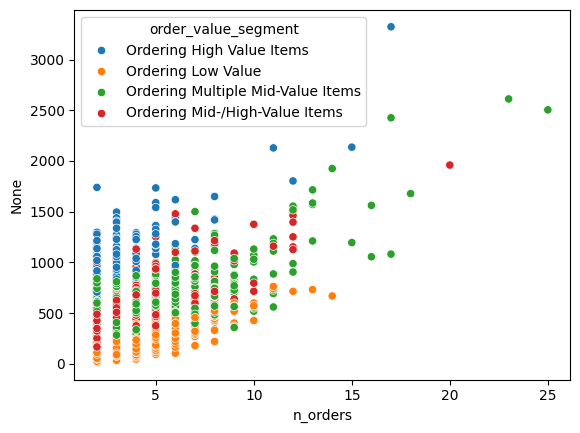

In [150]:
sns.scatterplot(repeat_purchasers, x='n_orders', y=total_spent, hue='order_value_segment', palette='tab10')

<Axes: xlabel='avg_days_to_order', ylabel='None'>

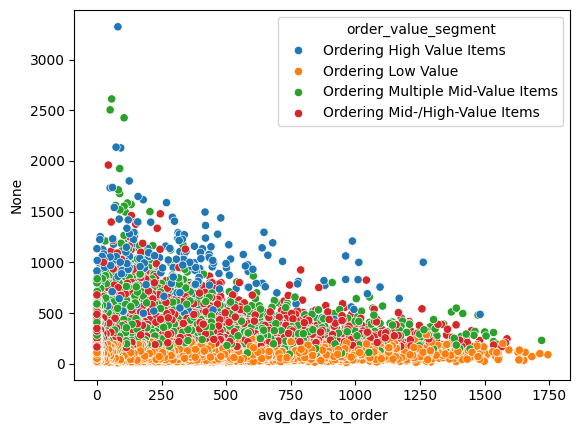

In [158]:
sns.scatterplot(repeat_purchasers, x='avg_days_to_order', y=total_spent, hue='order_value_segment', palette='tab10')

In [159]:
repeat_purchasers['segment'] = repeat_purchasers.loyalty_segment + ' - ' + repeat_purchasers.order_value_segment

In [161]:
repeat_purchasers['segment'].nunique()

23

In [162]:
customers_segmented = pd.concat([repeat_purchasers, one_off_customers, inactive_users])\
                        .sort_values('created_at')

In [163]:
customers_segmented.groupby(['segment'])['id'].count().sort_values(ascending=False)

segment
One-Off Customers                                                               36394
Never Ordered                                                                   25718
New Repeat Customer (Low Days-to-Order) - Ordering Low Value                     5900
New Repeat Customer (High Days-to-Order) - Ordering Low Value                    2958
New Repeat Customer (Mid Days-to-Order) - Ordering Low Value                     2339
New Repeat Customer (Low Days-to-Order) - Ordering Multiple Mid-Value Items      1997
New Repeat Customer (Low Days-to-Order) - Ordering Mid-/High-Value Items         1879
Potential Loyal Customers - Ordering Low Value                                   1365
New Repeat Customer (High Days-to-Order) - Ordering Multiple Mid-Value Items     1028
Potential Loyal Customers - Ordering Multiple Mid-Value Items                     996
New Repeat Customer (High Days-to-Order) - Ordering Mid-/High-Value Items         897
New Repeat Customer (Mid Days-to-Order) - Orde

In [164]:
customers_segmented.groupby(['segment', 'lifetime_status']).describe()

segment


In [185]:
for country in customers_segmented.country.unique():
    customers_filtered = customers_segmented[(customers_segmented.country==country) & (customers_segmented.n_orders>1)]
    print('Country:', country)
    print(customers_filtered['loyalty_segment'].value_counts() / customers_filtered.shape[0])
    print(50*'-')

Country: United States
loyalty_segment
New Repeat Customer (Low Days-to-Order)     0.445959
New Repeat Customer (High Days-to-Order)    0.224584
New Repeat Customer (Mid Days-to-Order)     0.175657
Potential Loyal Customers                   0.139964
Loyal Customer                              0.012633
High-Frequency Loyal Customer               0.001203
Name: count, dtype: float64
--------------------------------------------------
Country: United Kingdom
loyalty_segment
New Repeat Customer (Low Days-to-Order)     0.442105
New Repeat Customer (High Days-to-Order)    0.227751
New Repeat Customer (Mid Days-to-Order)     0.175120
Potential Loyal Customers                   0.140670
Loyal Customer                              0.014354
Name: count, dtype: float64
--------------------------------------------------
Country: China
loyalty_segment
New Repeat Customer (Low Days-to-Order)     0.457911
New Repeat Customer (High Days-to-Order)    0.224564
New Repeat Customer (Mid Days-to-Order)    

In [186]:
for country in customers_segmented.country.unique():
    customers_filtered = customers_segmented[(customers_segmented.country==country) & (customers_segmented.n_orders>1)]
    print('Country:', country)
    print(customers_filtered['order_value_segment'].value_counts() / customers_filtered.shape[0])
    print(50*'-')

Country: United States
order_value_segment
Ordering Low Value                   0.581512
Ordering Multiple Mid-Value Items    0.220975
Ordering Mid-/High-Value Items       0.184279
Ordering High Value Items            0.013234
Name: count, dtype: float64
--------------------------------------------------
Country: United Kingdom
order_value_segment
Ordering Low Value                   0.562679
Ordering Multiple Mid-Value Items    0.239234
Ordering Mid-/High-Value Items       0.176077
Ordering High Value Items            0.022010
Name: count, dtype: float64
--------------------------------------------------
Country: China
order_value_segment
Ordering Low Value                   0.567356
Ordering Multiple Mid-Value Items    0.232671
Ordering Mid-/High-Value Items       0.187812
Ordering High Value Items            0.012161
Name: count, dtype: float64
--------------------------------------------------
Country: Brasil
order_value_segment
Ordering Low Value                   0.583020
Orderin

In [187]:
for gender in customers_segmented.gender.unique():
    customers_filtered = customers_segmented[(customers_segmented.gender==gender) & (customers_segmented.n_orders>1)]
    print('Gender:', gender)
    print(customers_filtered['loyalty_segment'].value_counts() / customers_filtered.shape[0])
    print(50*'-')

Gender: F
loyalty_segment
New Repeat Customer (Low Days-to-Order)     0.465935
New Repeat Customer (High Days-to-Order)    0.220302
New Repeat Customer (Mid Days-to-Order)     0.178692
Potential Loyal Customers                   0.127023
Loyal Customer                              0.007956
High-Frequency Loyal Customer               0.000091
Name: count, dtype: float64
--------------------------------------------------
Gender: M
loyalty_segment
New Repeat Customer (Low Days-to-Order)     0.437523
New Repeat Customer (High Days-to-Order)    0.231758
New Repeat Customer (Mid Days-to-Order)     0.164995
Potential Loyal Customers                   0.147939
Loyal Customer                              0.016873
High-Frequency Loyal Customer               0.000912
Name: count, dtype: float64
--------------------------------------------------


In [188]:
for gender in customers_segmented.gender.unique():
    customers_filtered = customers_segmented[(customers_segmented.gender==gender) & (customers_segmented.n_orders>1)]
    print('Gender:', gender)
    print(customers_filtered['order_value_segment'].value_counts() / customers_filtered.shape[0])
    print(50*'-')

Gender: F
order_value_segment
Ordering Low Value                   0.595702
Ordering Multiple Mid-Value Items    0.226246
Ordering Mid-/High-Value Items       0.167627
Ordering High Value Items            0.010425
Name: count, dtype: float64
--------------------------------------------------
Gender: M
order_value_segment
Ordering Low Value                   0.556640
Ordering Multiple Mid-Value Items    0.220449
Ordering Mid-/High-Value Items       0.206950
Ordering High Value Items            0.015961
Name: count, dtype: float64
--------------------------------------------------


## Saving Pipelines

In [196]:
loyalty_segment_pipe = Pipeline([('scaler', scaler_loyalty), ('kmeans', kmeans_loyalty)])
order_value_segment_pipe = Pipeline([('scaler', scaler_order_value), ('pca', pca_order_value), ('kmeans', kmeans_order_value)])

In [197]:
# with open('../models/loyalty_segment_pipe.pkl', 'wb') as f:
#     pkl.dump(loyalty_segment_pipe, f)
# 
# with open('../models/order_value_segment_pipe.pkl', 'wb') as f:
#     pkl.dump(order_value_segment_pipe, f)

In [198]:
with open('../models/loyalty_segment_pipe.pkl', 'rb') as f:
    loyalty_segment_pipe_loaded = pkl.load(f)

with open('../models/order_value_segment_pipe.pkl', 'rb') as f:
    order_value_segment_pipe_loaded = pkl.load(f)

In [199]:
loyalty_labels = loyalty_segment_pipe_loaded.predict(X_loyalty)
(loyalty_labels == kmeans_loyalty.labels_).all()

np.True_

In [201]:
order_value_labels = order_value_segment_pipe_loaded.predict(X_order_value)
(order_value_labels == kmeans_order_value.labels_).all()

np.True_

In [202]:
with open('../models/loyalty_segment_map.json', 'w') as f:
    json.dump(loyalty_segment_map, f)

with open('../models/order_value_segment_map.json', 'w') as f:
    json.dump(order_value_segment_map, f)

In [203]:
with open('../models/loyalty_segment_map.json', 'r') as f:
    loyalty_segment_map_loaded = json.load(f)

with open('../models/order_value_segment_map.json', 'r') as f:
    order_value_segment_map_loaded = json.load(f)

In [204]:
loyalty_segment_map_loaded

{'0': 'New Repeat Customer (Mid Days-to-Order)',
 '1': 'Potential Loyal Customers',
 '2': 'New Repeat Customer (High Days-to-Order)',
 '3': 'Loyal Customer',
 '4': 'New Repeat Customer (High Days-to-Order)',
 '5': 'Potential Loyal Customers',
 '6': 'New Repeat Customer (Low Days-to-Order)',
 '7': 'New Repeat Customer (Low Days-to-Order)',
 '8': 'New Repeat Customer (High Days-to-Order)',
 '9': 'High-Frequency Loyal Customer',
 '10': 'Loyal Customer'}

In [205]:
order_value_segment_map_loaded

{'0': 'Ordering Low Value',
 '1': 'Ordering Multiple Mid-Value Items',
 '2': 'Ordering Mid-/High-Value Items',
 '3': 'Ordering High Value Items'}